<a href="https://colab.research.google.com/github/aguschanchu/FermionicML/blob/main/FermionicML_thermal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FermionicML:

Code based on aguschanchu/Bosonic.py

A diferencia del código anterior, este modelo trabaja sobre estados térmicos

## Código base

Cargamos el código de Bosonic.py básico, branch fermionic

In [1]:
import numpy as np
from scipy.special import binom
from scipy.sparse import dok_matrix, linalg
from scipy import linalg as linalg_d
from joblib import Memory
import random
import plotly.graph_objects as go
from joblib import Parallel, delayed
from numba import jit, prange, njit
import numba as nb
import pickle
import math
import tensorflow_probability as tfp

# Funciones auxiliares optimiadas
@nb.jit(nopython=True, parallel=True)
def int_to_tuple_arr(ni,nf, b, digits=None):
    sol = np.zeros((nf-ni, digits), dtype=np.int64)
    for n in prange(ni, nf):
        r = np.zeros(digits, dtype=np.int64)
        ncop = n
        idx = 0
        while n != 0:
            r[idx] = n % b
            n = n // b
            idx += 1
        if digits is not None:
            if idx < digits:
                for i in range(idx, digits):
                    r[i] = 0
                idx = digits
        sol[ncop-ni,:] = r[:idx]
    return sol

def tuple_to_int(t, d):
    b = d-1
    l = len(t)
    s = [t[k]*b**(l-k-1) for k in range(0,l)]
    return sum(s)

def create_basis_(m, d, size):
    base = []
    index = 0
    chunk_size = 1000000
    for x in range(0,(m+1)**d, chunk_size):
        start_index = x
        end_index = min(x + chunk_size, (m+1)**d)
        arr = int_to_tuple_arr(start_index, end_index, m+1, d)
        sums = np.sum(arr, axis=1)
        rows = np.where(sums == m)[0]
        for row in [arr[i] for i in rows]:
            if np.all(np.logical_or(row == 0, row == 1)):
                base.append(row)

    # Como consecuencia de la paralelizacion, es necesario reordenar la base
    sorted_base = sorted(base, key=lambda x: tuple_to_int(x, d), reverse=True)
    assert len(base) == size

    return sorted_base

class fixed_basis:

    # Convierte a un enterno n a su escritura en base b
    def _int_to_tuple(self, n, b, digits = None):
        rep = np.base_repr(n, b)
        rep_int = [int(x,b) for x in rep]
        if digits is not None:
            zeros = [0 for i in range(0,digits-len(rep))]
            return zeros + rep_int
        else:
            return rep_int

    # Revierte la transformacion anterior
    def tuple_to_int(self, t):
        b = self.d-1
        l = len(t)
        s = [t[k]*b**(l-k-1) for k in range(0,l)]
        return sum(s)

    # Convierte el vector en su representacion
    def vect_to_repr(self, vect):
        for i, k in enumerate(vect):
            if k == 1. or k == 1:
                break
        else:
            return 0
        return self.base[i,:]

    def rep_to_vect(self, rep):
        rep = list(rep)
        for i, r in [(j, self.base[j,:]) for j in range(0,self.size)]:
            if list(r) == rep:
                return self.canonicals[:,i]
        else:
            None

    def rep_to_index(self, rep):
        return self.base.tolist().index(list(rep))

    @staticmethod
    def rep_to_exi(rep):
        r = []
        for i, k in enumerate(rep):
            r += [i for x in range(0,k)]
        return r

    # Crea base de M particulas en D estados (repr y base canonica)
    def create_basis(self, m, d):
        #print("Creating basis: ", m, d)
        length = int(binom(d,m))
        base = np.array(create_basis_(m, d, length))
        # Asignamos a cada uno de ellos un canónico
        canonicals = np.eye(length)
        return base, canonicals

    def __init__(self, m, d):
        self.m = m
        self.d = d
        self.size = int(binom(d,m))
        (self.base, self.canonicals) = self.create_basis(m, d)


# Matrices de aniquilación y creación endomórficas. Estan fuera de la clase para poder ser cacheadas
#@memory.cache
def bdb(basis, i, j):
    mat = dok_matrix((basis.size, basis.size), dtype=np.float32)
    if i != j:
        for k, v in enumerate(basis.base):
            if v[j] != 0 and v[i] != 1:
                dest = list(v.copy())
                dest[j] -= 1
                dest[i] += 1
                tar = basis.rep_to_index(dest)
                mat[tar, k] = np.sqrt(v[i]+1)*np.sqrt(v[j])
    else:
        for k, v in enumerate(basis.base):
            if v[j] != 0:
                mat[k, k] = v[i]
    return mat

#@memory.cache
def bbd(basis, i, j):
    mat = dok_matrix((basis.size, basis.size), dtype=np.float32)
    if i != j:
        for k, v in enumerate(basis.base):
            if v[i] != 0 and v[j] != 1:
                dest = list(v.copy())
                dest[i] -= 1
                dest[j] += 1
                tar = basis.rep_to_index(dest)
                mat[tar, k] = np.sqrt(v[j]+1)*np.sqrt(v[i])
    else:
        for k, v in enumerate(basis.base):
            if v[i] != 1:
                mat[k, k] = v[i]+1
    return mat

# Matrices de aniquilación y creación.Toman la base de origen y destino (basis_o, basis_d) resp
#@nb.jit(nopython=True, parallel=True)
@nb.jit(nopython=True)
def b_aux(basis_o, basis_d, i):
    mat = np.zeros((len(basis_d), len(basis_o)), dtype=np.float32)
    for k in prange(len(basis_o)):
        if basis_o[k][i] != 0:
            dest = list(basis_o[k].copy())
            dest[i] -= 1
            for j in prange(len(basis_d)):
                if list(basis_d[j]) == dest:
                    tar = j
                    mat[tar, k] = np.sqrt(basis_o[k][i])
    return mat

def b(basis_o, basis_d, i):
    return b_aux(basis_o.base, basis_d.base, i)

#@nb.jit(nopython=True, parallel=True)
@nb.jit(nopython=True)
def bd_aux(basis_o, basis_d, i):
    mat = np.zeros((len(basis_d), len(basis_o)), dtype=np.float32)
    for k in prange(len(basis_o)):
        if basis_o[k][i] != 1:
            dest = list(basis_o[k].copy())
            dest[i] += 1
            for j in prange(len(basis_d)):
                if list(basis_d[j]) == dest:
                    tar = j
                    mat[tar, k] = np.sqrt(basis_o[k][i]+1)
    return mat

def bd(basis_o, basis_d, i):
    return bd_aux(basis_o.base, basis_d.base, i)


# Acepta una lista de indices a crear
@nb.jit(nopython=True, parallel=True)
def bd_gen_aux(basis_o, basis_d, gen_list):
    mat = np.zeros((len(basis_d), len(basis_o)), dtype=np.float32)
    for k in prange(len(basis_o)):
        conds = np.zeros(len(gen_list), dtype=np.int64)
        for i in range(len(gen_list)):
            if basis_o[k][gen_list[i]] != 1:
                conds[i] = 1
        if np.all(conds):
            dest = list(basis_o[k].copy())
            for i in gen_list:
                dest[i] += 1
            for j in prange(len(basis_d)):
                if list(basis_d[j]) == dest:
                    tar = j
                    mat[tar, k] = np.sqrt(basis_o[k][i]+1)
    return mat

def bd_gen(basis_o, basis_d, i):
    return bd_gen_aux(basis_o.base, basis_d.base, np.array(i))

def b_gen(basis_o, basis_d, i):
    return np.transpose(bd_gen(basis_d, basis_o, i))

# Volvemos a definir la función para compilarla
@nb.jit(forceobj=True)
def _rep_to_index(base, rep):
    return base.tolist().index(list(rep))

# Funciones auxiliares para calcular rho2kkbar y gamma_p
@nb.jit(nopython=True)
def rep_to_exi(rep):
    r = []
    for i in range(len(rep)):
        for j in range(rep[i]):
            r.append(i)
    return r

@nb.njit
def factorial(n):
    result = 1
    for i in range(1, n + 1):
        result *= i
    return result

@nb.njit
def gamma_lamba(x):
    res = 1.0
    for o in x:
        res *= math.sqrt(factorial(o))
    return res

@nb.jit
def gamma_lamba_inv(x):
    res = 1.0
    for o in x:
        res *= 1.0 / np.sqrt(factorial(o))
    return res

@nb.njit
def rep_to_index_np(base, rep):
    for i in range(len(base)):
        if np.all(base[i] == rep):
            return i
    return -1


def gamma_p(basis, m, vect, m_basis = None, nm_basis = None):
    d = basis.d
    if not m_basis or not nm_basis:
        m_basis = fixed_basis(m, d)
        nm_basis = fixed_basis(basis.m-m,d)
    return gamma_p_aux(basis.base, vect, m_basis.base, nm_basis.base)

@nb.njit()
def gamma_p_aux(basis, vect, m_basis, nm_basis):
    mat = np.zeros((len(m_basis), len(nm_basis)), dtype=np.float32)
    for i in prange(len(m_basis)):
        v = m_basis[i]
        for j in prange(len(nm_basis)):
            w = nm_basis[j]
            targ = v + w
            index = rep_to_index_np(basis, targ)
            if index != -1:
                coef = vect[index]
                if coef != 0:
                    coef = coef * gamma_lamba_inv(v) * gamma_lamba_inv(w) * gamma_lamba(targ)
                mat[i, j] = coef
    return mat
# Devuelve la matriz rho M asociada al vector
def rho_m(basis, m, vect, m_basis = None, nm_basis = None):
    g = gamma_p(basis, m, vect, m_basis, nm_basis)
    return np.dot(g,np.transpose(g))

# Devuelve la matriz gamma asociada a la descomposición (M,N-M) del vector
@jit(forceobj=True)
def gamma(basis, m, vect, m_basis = None, nm_basis = None):
    d = basis.d
    if not m_basis or not nm_basis:
        m_basis = fixed_basis(m, d)
        nm_basis = fixed_basis(basis.m-m,d)
    mat = dok_matrix((m_basis.size, nm_basis.size), dtype=np.float32)
    for i, v in enumerate(m_basis.base):
        for j, w in enumerate(nm_basis.base):
            targ = v+w
            # Revisamos que sea un estado fermionico valido
            arr = np.asarray(targ)
            if not np.all(np.logical_or(arr == 0, arr == 1)):
                continue
            index = _rep_to_index(basis.base, targ)
            coef = vect[index]
            if coef != 0:
                aux = lambda x: np.prod(np.reciprocal(np.sqrt([np.math.factorial(o) for o in x])))
                aux_inv = lambda x: np.prod(np.sqrt([np.math.factorial(o) for o in x]))
                coef = coef * aux(v) * aux(w) * aux_inv(targ)
                #coef = coef
                #print(v,w,coef)
            mat[i,j] = coef
    return mat

# Genera las matrices de rho1
def rho_1_gen(basis):
    d = basis.d
    s = basis.size
    mat = np.empty((d,d,s,s), dtype=np.float32)
    for i in range(0, d):
        for j in range(0, d):
            mat[i,j,:,:] = np.array(bdb(basis,j, i).todense())
    return mat

#@jit(parallel=True, nopython=True)
def rho_1(d, state, rho_1_arrays):
    state_expanded = state[np.newaxis, np.newaxis, :, :]
    product = state_expanded * rho_1_arrays
    mat = np.sum(product, axis=(-2, -1))

    return mat


# Genera las matrices de rho2
def rho_2_gen(basis, mll_basis, t_basis):
    size = t_basis.size
    s = basis.size
    # La entrada i, j contiene C_j^\dag C_i    i, j \in t_basis
    mat = np.empty((size, size, s, s), dtype=np.float32)
    for i, v in enumerate(t_basis.base):
        for j, w in enumerate(t_basis.base):
            c_i = b_gen(basis, mll_basis, rep_to_exi(v))
            cdag_j = bd_gen(mll_basis, basis, rep_to_exi(w))
            mat[i, j, :, :] = np.dot(cdag_j, c_i)

    return mat

def rho_2(size, state, rho_2_arrays):
    state_expanded = np.expand_dims(state, axis=1)
    state_expanded = np.expand_dims(state_expanded, axis=1)
    rho_2_arrays = rho_2_arrays[np.newaxis, :, :, :, :]
    print(state_expanded.shape, rho_2_arrays.shape)
    product = state_expanded * rho_2_arrays
    mat = np.sum(product, axis=(-2, -1))
    return mat

def rho_2_kkbar_gen(m, rho_2_arrays):
    offset = 4*m+1
    indices = [-(k-1)*(2*k-offset) for k in range(1,m+1)] # Lo saque de Mathmatica, vos confia
    i, j = np.meshgrid(indices, indices, indexing='ij') # Lo usamos para rellenar la mat deseada

    rho_2_arrays_kkbar = rho_2_arrays[i, j, :, :]

    return rho_2_arrays_kkbar

# Devuelve la matriz rho 2 asociada al bloque kkbar
def rho_2_kkbar(basis, vect, ml_basis = None, mll_basis = None, t_basis = None):
    d = basis.d
    # Creo las bases si no están dadas
    if ml_basis == None or mll_basis == None or t_basis == None:
        ml_basis = fixed_basis(m-1,d)
        mll_basis = fixed_basis(m-2,d)
        t_basis = fixed_basis(2,d)
    diag = []
    for v in t_basis.base:
        for j in range(0, d, 2):
            if v[j] == v[j+1]:
                continue
            else:
                break
        else:
            diag.append(v)
    diag = np.array(diag)
    return rho_2_kkbar_aux(diag, vect, basis.base, ml_basis.base, mll_basis.base, t_basis.base)

@nb.njit
def rho_2_kkbar_lambda(x):
    res = 1.0
    for o in x:
        res *= 1.0 / math.sqrt(factorial(o))
    return res

#@nb.njit(parallel=True)
def rho_2_kkbar_aux(diag, vect, basis, ml_basis, mll_basis, t_basis):
    mat = np.zeros((len(diag), len(diag)), dtype=np.float32)
    for i in prange(len(diag)):
        for j in prange(len(diag)):
            v = diag[i]
            w = diag[j]
            # Creacion de los a
            i_set = rep_to_exi(v)
            b_m = b_aux(ml_basis, mll_basis, i_set[1]) @ b_aux(basis, ml_basis, i_set[0])
            # Creacion de los ad
            i_set = rep_to_exi(w)
            bd_m = bd_aux(ml_basis, basis, i_set[1]) @ bd_aux(mll_basis, ml_basis, i_set[0])
            # v1 = vect @ bd_m @ b_m @ vect Para estados puros
            # Mult de b's y filleo de mat
            coef = np.trace(vect @ bd_m @ b_m)
            mat[i,j] = coef * rho_2_kkbar_lambda(v) * rho_2_kkbar_lambda(w)
    return mat


/var/tmp/ipykernel_88660/3558866515.py:248: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def gamma_lamba_inv(x):


## Definicion de Hamiltoniano

Cargamos el código de creación y resolución de Hamiltonianos

In [2]:
m = 3
d = 6
# Creo las bases para no tener que recrearlas luego
basis = fixed_basis(m, d)
basis_m1 = fixed_basis(m-1, d)
basis_m2 = fixed_basis(m-2, d)

In [29]:
## Usamos este approach si queremos guardar los generadores
# Dados 1/2 (d^2+d) elementos, genera una mat de dxd:
eps = 0.00001

def sym_mat_gen(vect, d):
    matrix = fill_matrix(vect, d)
    return matrix + matrix.T - np.diag(matrix.diagonal())

@jit(nopython=True)
def fill_matrix(vect, d):
    matrix = np.zeros((d, d))
    idx = 0
    for i in prange(d):
        for j in prange(i, d):
            matrix[i, j] = vect[idx]
            idx += 1
    return matrix

# Generamos una matrix aleatoria. Cuidado con la distribución, ver https://stackoverflow.com/questions/56605189/is-there-an-efficient-way-to-generate-a-symmetric-random-matrix
def hamil_base_gen(d):
    U = np.random.uniform(low=0, high=1.0, size=(d, d))
    hamil_base = np.tril(U) + np.tril(U, -1).T
    return hamil_base

# Dada un a mat dxd simetrica, contruye el hamiltoniano de un cuerpo a_{ij} c^{dag}_i c_j
# Alternativamente podemos construirlo a partir de rho_1_gen
def base_hamiltonian_aux(mat, size, d, rho_1_gen):
    # Construccion de H
    rho_1_gen_transposed = rho_1_gen.transpose(1, 0, 2, 3)
    mat_expanded = mat[:, :, np.newaxis, np.newaxis]
    h = np.sum(mat_expanded * rho_1_gen_transposed[:, :, :, :], axis=(0, 1))
    return h.astype(np.float32)

def base_hamiltonian(mat, basis, rho_1_gen):
    return base_hamiltonian_aux(mat, basis.size, basis.d, rho_1_gen)

def two_body_hamiltonian(t_basis_size, m, energy, G, rho_1_arrays, rho_2_arrays):
    # Creamos la mat diagonal de d*d con los elementos de energy
    # cada uno de estos, se contraen con los elementos de rho_1_arrays
    # la mat energy contiene las energias de cada termino c^\dag_k c_k para k kbar (iguales)
    # por ello los elementos se repiten 
    energy_matrix = np.diagflat(np.kron(energy, np.ones(2))) + eps * np.random.random((2*m,2*m))
    
    # Construimos la mat de energía
    h0 = np.sum(energy_matrix[:, :, np.newaxis, np.newaxis] * rho_1_arrays[:, :, :, :], axis=(0, 1))

    # Pasamos ahora a la matrix de interacción con la misma estrategia
    # dada G que indica la interacción entre los pares k' k'bar k kbar 
    # (que son elementos particulares de t_basis)
    # transladamos estos coeficientes a una matriz en t_basis
    # y multiplicamos por rho_2_arrays
    
    # Primero determinamos, dada t_basis, cuales son los indices de pares kkbar
    offset = 4*m+1
    indices = [-(k-1)*(2*k-offset) for k in range(1,m+1)] # Lo saque de Mathmatica, vos confia
    i, j = np.meshgrid(indices, indices, indexing='ij') # Lo usamos para rellenar la mat deseada
    
    # Contruimos la mat que contraeremos con rho_2_arrays
    mat = np.zeros((t_basis_size, t_basis_size))
    mat[i, j] = G

    hi = -np.sum(mat[:, :, np.newaxis, np.newaxis] * rho_2_arrays[:, :, :, :], axis=(0, 1))

    return (h0, hi)

def solve(h, last_step = None):
    sol = linalg.eigsh(h, which='SA',k=19)
    eigenspace_tol = 0.0001
    if type(last_step) != type(None):
        # Seleccionamos todos los autovects que difieren sus autovalores menos que tol (mismo autoespacio)
        # y tomamos la proyección en el autoespacio de la solución del paso anterior (last_step)
        eig = sol[0].real
        eigv = sol[1]
        cand = [eigv[:,i].real  for (i, x) in enumerate(eig) if abs(x-min(eig)) < eigenspace_tol]
        cand_norm = [x/np.linalg.norm(x) for x in cand]
        fund = np.zeros(len(cand[0]))
        for x in cand_norm:
            fund += np.dot(last_step,x) * x
    else:
        argmin = np.argmin(sol[0].real)
        fund = sol[1][:,argmin]
    fund = fund.real / np.linalg.norm(fund)
    return fund

In [4]:
def two_body_hamiltonian_tf(t_basis_size, m, energy, G, rho_1_arrays, rho_2_arrays):
    eps = 1e-8  # Add a small epsilon to avoid potential numerical issues
    
    # Convert NumPy arrays to TensorFlow tensors
    energy_matrix = tf.linalg.diag(tf.concat([energy, energy], axis=0)) + eps * tf.random.normal((2 * m, 2 * m))

    # Construct the energy matrix
    h0 = tf.reduce_sum(tf.einsum('ij,jk...->...k', energy_matrix, rho_1_arrays), axis=-1)

    # Determine indices of pairs kkbar
    offset = 4 * m + 1
    indices = [-(k - 1) * (2 * k - offset) for k in range(1, m + 1)]
    i, j = tf.meshgrid(indices, indices, indexing='ij')

    # Construct the matrix for contraction with rho_2_arrays
    updates = tf.reshape(G, [-1])
    indices = tf.reshape(tf.stack([i, j], axis=-1), [-1, 2])
    mat = tf.tensor_scatter_nd_add(tf.zeros((t_basis_size, t_basis_size)), indices, updates)

    hi = -tf.reduce_sum(tf.einsum('ij...,ijk...->...k', mat, rho_2_arrays), axis=-1)

    return h0, hi

(h0, hi) = two_body_hamiltonian(t_basis.size, basis.m, 1.0*np.arange(0, basis.m), 0.5 * np.ones((m,m)), rho_1_arrays_tf, rho_2_arrays_tf)
(h02, hi2) = two_body_hamiltonian_tf(t_basis.size, basis.m, tf.constant(1.0*np.arange(0, basis.m), dtype=tf.float32), tf.constant(0.5 * np.ones((m,m)), dtype=tf.float32), rho_1_arrays_tf, rho_2_arrays_tf)


NameError: name 't_basis' is not defined

## Modelo de ML
Basado en matrices densidad de 1 y 2 cuerpos como input, con hamiltoniano como salida

In [5]:
import tensorflow as tf
import numpy as np
tf.test.gpu_device_name()


2023-12-06 20:15:38.997154: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-06 20:15:39.048096: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 20:15:39.048133: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 20:15:39.048179: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 20:15:39.057240: I tensorflow/core/platform/cpu_feature_g

'/device:GPU:0'

In [6]:
# Construccion de bases para calculo de rho1 y rho2
# rho2
m = 2
m2_basis = fixed_basis(m, d)
print(m2_basis.size)
nm2_basis = fixed_basis(basis.m-m, d)
print(nm2_basis.base)
t_basis = fixed_basis(2, basis.d)
# rho1
m = 1
m1_basis = fixed_basis(m, d)
print(m1_basis.size)
print(m1_basis.base)
nm1_basis = fixed_basis(basis.m-m, d)


15
[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]]
6
[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]]


### Algunos benchmarks y funciones auxiliares

In [7]:
# Given h calculo en rho2 y rho1 máximo
def rho1_rho2(h, beta):
    fund = thermal_state(h, beta)
    rho2 = np.array(rho_2(basis, m2_basis.size, state, rho_2_arrays))
    r = np.sort(linalg_d.eigvals(rho2).real)
    rho_2_max = r[0]
    rho1 = np.array(rho_1(basis, state, rho_1_arrays))
    r = np.sort(linalg_d.eigvals(rho1).real)
    rho_1_max = r[0]

    return (rho_1_max, rho_2_max)

def fill_triangular_np(x):
    m = x.shape[0]
    n = np.int32(np.sqrt(.25 + 2 * m) - .5)
    x_tail = x[(m - (n**2 - m)):]
    return np.triu(np.concatenate([x, x_tail[::-1]], 0).reshape(n, n))


In [8]:
# TEST: Las funciones de TF y comunes coinciden

# Dado h, \beta, construyo el estado térmico
from scipy.linalg import expm

def thermal_state(h, beta):
    quotient = expm(-beta*h)
    return quotient / np.trace(quotient)

## NO usar para mat no hermiticas
@nb.jit(nopython=True)
def thermal_state_eig(h, beta):
    w, v = np.linalg.eigh(-beta*h)
    D = np.diag(np.exp(w))
    mat = v @ D @ v.T
    mat = mat / np.trace(mat)
    return mat
    
def gen_to_h(base, rho_1_arrays):
    triag = fill_triangular_np(base)
    body_gen = triag + np.transpose(triag)-np.diag(np.diag(triag))
    h = np.array(base_hamiltonian(body_gen, basis, rho_1_arrays))  
    return h 

def gen_to_h_1b(hamil_base):
    triag = tfp.math.fill_triangular(hamil_base, upper=True)
    body_gen = triag + tf.transpose(triag, perm=[0,2,1])-tf.linalg.diag(tf.linalg.diag_part(triag))
    return body_gen

def gen_to_h_tf(hamil_base, rho_1_arrays):
    triag = tfp.math.fill_triangular(hamil_base, upper=True)
    body_gen = triag + tf.transpose(triag, perm=[0,2,1])-tf.linalg.diag(tf.linalg.diag_part(triag)) # Simetrizamos y generamos la matriz de h
    hamil_expanded = body_gen[:, :, :, np.newaxis, np.newaxis]
    rho_1_gen_transposed = tf.transpose(rho_1_arrays, perm=[1, 0, 2, 3])
    h_arr = tf.reduce_sum(hamil_expanded * rho_1_gen_transposed[np.newaxis,:,:,:,:], axis=[1,2])
    return h_arr

def thermal_state_tf(h):
    # Assume beta=1
    exp_hamiltonian = tf.linalg.expm(-h)
    partition_function = tf.linalg.trace(exp_hamiltonian)
    partition_function = tf.expand_dims(partition_function, axis=1)
    partition_function = tf.expand_dims(partition_function, axis=1)
    
    rho = exp_hamiltonian / partition_function

    return rho

def rho_1_tf(state, rho_1_arrays):
    state = tf.expand_dims(state, axis=1)  # Shape: (5120, 10, 1, 10)
    state_expanded = tf.expand_dims(state, axis=1)
    rho_1_arrays_expanded = tf.expand_dims(rho_1_arrays, axis=0)  # Shape: (1, 5, 5, 10, 10)
    product = state_expanded * rho_1_arrays_expanded  # Shape: (5120, 10, 5, 10, 10)
    mat = tf.reduce_sum(product, axis=[-2, -1])  # Shape: (5120, 5, 5)
    
    return mat

def rho_2_tf(state, rho_2_arrays):
    state = tf.expand_dims(state, axis=1)  # Shape: (5120, 10, 1, 10)
    state_expanded = tf.expand_dims(state, axis=1)
    rho_2_arrays_expanded = tf.expand_dims(rho_2_arrays, axis=0)  # Shape: (1, 5, 5, 10, 10)
    product = state_expanded * rho_2_arrays_expanded  # Shape: (5120, 10, 5, 10, 10)
    mat = tf.reduce_sum(product, axis=[-2, -1])  # Shape: (5120, 5, 5)
    
    return mat

# NOTA: para calcular el bloque rho2kkbar, utilizar en lugar

def rho_1_gc_tf(hamil_base):
    e, v = tf.linalg.eigh(gen_to_h_1b(hamil_base))
    result = 1 / (1 + tf.exp(e))
    result = tf.linalg.diag(result)
    res = tf.linalg.matmul(v,result)
    res = tf.linalg.matmul(res,v,adjoint_b=True)
    
    return tf.cast(res, tf.float32)

# Aux function
def outer_product(vector):
    return tf.einsum('i,j->ij', vector, vector)

def pure_state(h):
    e, v = tf.linalg.eigh(h)
    fund = v[:,:,0]
    d = tf.map_fn(outer_product, fund)
    return d
    

### Construccion de dataset

#### Version sincrónica

In [43]:
import time
from tqdm import tqdm
# Config
num_samples = 50000
use_gpu = True
gpu_batch_size = 1024
beta = 0.1 

# Beta variable
betas = np.logspace(-2,2,100)
ds_set = {}

# Construccion de parametros y matrices auxiliares
rho1_size = m1_basis.size
rho2_size = m2_basis.size
fund_size = basis.size
hamil_base_size = basis.d*(basis.d+1)//2
rho_1_arrays = rho_1_gen(basis)
rho_1_arrays_tf = tf.constant(rho_1_arrays, dtype=tf.float32)
rho_2_arrays = rho_2_gen(basis, nm2_basis, m2_basis)
rho_2_arrays_tf = tf.constant(rho_2_arrays, dtype=tf.float32)
rho_2_arrays_kkbar = rho_2_kkbar_gen(basis.m, rho_2_arrays)
rho_2_arrays_kkbar_tf = tf.constant(rho_2_arrays_kkbar, dtype=tf.float32)

# Generacion de hamiltoniano
(h0, hi) = two_body_hamiltonian(t_basis.size, basis.m, np.arange(0, basis.m), np.ones((basis.m,basis.m)), rho_1_arrays_tf, rho_2_arrays_tf)

for beta in betas:
    if use_gpu:
        print(tf.test.gpu_device_name())
        datasets = []
        for i in tqdm(range(num_samples//gpu_batch_size+1)):
            size = basis.d*(basis.d+1)//2
            # En una primera versión vamos a pasar una mat proporcional a range(0,m) para energias
            # y como interacción una cte G por ones(m,m)
            h_labels = [np.random.rand()*5 for _ in range(0,gpu_batch_size)] # Generamos los generadores
            hamil_base = tf.constant(h_labels, dtype=tf.float32)
            h_arr = np.zeros((gpu_batch_size, basis.size, basis.size))
            for i, g in enumerate(h_labels):
                h_arr[i,:,:] = h0 - g * hi
            # Estados térmicos
            state = thermal_state_tf(h_arr*beta) 
            state = tf.cast(state, dtype=tf.float32)
            # Estados puros
            #state = pure_state(h_arr)
            #rho_1_input = rho_1_tf(state, rho_1_arrays_tf)
            rho_2_input = rho_2_tf(state, rho_2_arrays_kkbar_tf)

            datasets.append(tf.data.Dataset.from_tensor_slices(((rho_2_input), h_labels)))
            #datasets.append(tf.data.Dataset.from_tensor_slices(((rho_1_input, rho_2_input), h_labels)))
            #datasets.append(tf.data.Dataset.from_tensor_slices(((rho_1_input, rho_2_input, state), h_labels)))
        ds = tf.data.Dataset.from_tensor_slices(datasets)
        dataset = ds.interleave(
            lambda x: x,
            cycle_length=1,
            num_parallel_calls=tf.data.AUTOTUNE,
        )
        ds_set[beta] = dataset


#batch_size = 32
#dataset = dataset.shuffle(buffer_size=num_samples).batch(batch_size)

2023-12-06 22:30:33.135435: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.16it/s]
2023-12-06 22:30:34.633969: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.49it/s]
2023-12-06 22:30:36.117263: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.36it/s]
2023-12-06 22:30:37.605790: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.15it/s]
2023-12-06 22:30:39.104883: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.66it/s]
2023-12-06 22:30:40.580465: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.62it/s]
2023-12-06 22:30:42.057508: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.64it/s]
2023-12-06 22:30:43.533519: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.67it/s]
2023-12-06 22:30:45.008498: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.82it/s]
2023-12-06 22:30:46.476833: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.31it/s]
2023-12-06 22:30:47.967987: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.39it/s]
2023-12-06 22:30:49.455904: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.45it/s]
2023-12-06 22:30:50.941005: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.75it/s]
2023-12-06 22:30:52.457551: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.98it/s]
2023-12-06 22:30:53.919626: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.67it/s]
2023-12-06 22:30:55.394941: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.16it/s]
2023-12-06 22:30:56.893155: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.56it/s]
2023-12-06 22:30:58.373540: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.35it/s]
2023-12-06 22:30:59.863207: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.42it/s]
2023-12-06 22:31:01.349704: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.95it/s]
2023-12-06 22:31:02.857133: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.07it/s]
2023-12-06 22:31:04.358655: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.53it/s]
2023-12-06 22:31:05.839879: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.99it/s]
2023-12-06 22:31:07.345549: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.29it/s]
2023-12-06 22:31:08.838318: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.35it/s]
2023-12-06 22:31:10.328796: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.12it/s]
2023-12-06 22:31:11.828471: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.85it/s]
2023-12-06 22:31:13.340235: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.22it/s]
2023-12-06 22:31:14.835526: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.60it/s]
2023-12-06 22:31:16.314175: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.65it/s]
2023-12-06 22:31:17.790770: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.71it/s]
2023-12-06 22:31:19.265171: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.98it/s]
2023-12-06 22:31:20.727093: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 34.05it/s]
2023-12-06 22:31:22.185613: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.85it/s]
2023-12-06 22:31:23.652455: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.67it/s]
2023-12-06 22:31:25.127522: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 34.04it/s]
2023-12-06 22:31:26.586687: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.40it/s]
2023-12-06 22:31:28.074084: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.72it/s]
2023-12-06 22:31:29.546950: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.38it/s]
2023-12-06 22:31:31.034358: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.69it/s]
2023-12-06 22:31:32.553010: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.61it/s]
2023-12-06 22:31:34.030120: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.51it/s]
2023-12-06 22:31:35.511243: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.59it/s]
2023-12-06 22:31:36.989341: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.81it/s]
2023-12-06 22:31:38.457666: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 34.77it/s]
2023-12-06 22:31:39.886146: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 34.99it/s]
2023-12-06 22:31:41.305588: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 34.21it/s]
2023-12-06 22:31:42.756974: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 34.06it/s]
2023-12-06 22:31:44.214597: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 34.44it/s]
2023-12-06 22:31:45.656648: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.43it/s]
2023-12-06 22:31:47.141643: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 34.38it/s]
2023-12-06 22:31:48.586508: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.48it/s]
2023-12-06 22:31:50.070100: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.25it/s]
2023-12-06 22:31:51.563357: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.20it/s]
2023-12-06 22:31:53.058594: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.82it/s]
2023-12-06 22:31:54.570728: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.72it/s]
2023-12-06 22:31:56.043569: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.42it/s]
2023-12-06 22:31:57.528990: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.65it/s]
2023-12-06 22:31:59.004164: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.28it/s]
2023-12-06 22:32:00.496362: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.08it/s]
2023-12-06 22:32:01.996841: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.85it/s]
2023-12-06 22:32:03.507847: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.97it/s]
2023-12-06 22:32:05.013714: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.02it/s]
2023-12-06 22:32:06.517536: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.78it/s]
2023-12-06 22:32:08.032061: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.84it/s]
2023-12-06 22:32:09.543950: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.51it/s]
2023-12-06 22:32:11.070530: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.97it/s]
2023-12-06 22:32:12.576265: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.77it/s]
2023-12-06 22:32:14.090720: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.01it/s]
2023-12-06 22:32:15.594624: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.41it/s]
2023-12-06 22:32:17.125636: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.44it/s]
2023-12-06 22:32:18.655672: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.46it/s]
2023-12-06 22:32:20.184652: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.49it/s]
2023-12-06 22:32:21.712158: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.37it/s]
2023-12-06 22:32:23.245046: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.09it/s]
2023-12-06 22:32:24.791110: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 31.98it/s]
2023-12-06 22:32:26.343022: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 31.86it/s]
2023-12-06 22:32:27.900325: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 31.62it/s]
2023-12-06 22:32:29.469296: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 31.34it/s]
2023-12-06 22:32:31.051700: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 31.27it/s]
2023-12-06 22:32:32.638392: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 31.19it/s]
2023-12-06 22:32:34.228819: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 31.51it/s]
2023-12-06 22:32:35.802814: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 31.21it/s]
2023-12-06 22:32:37.391814: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 31.30it/s]
2023-12-06 22:32:38.976481: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 31.48it/s]
2023-12-06 22:32:40.552149: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 31.50it/s]
2023-12-06 22:32:42.127590: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 31.28it/s]
2023-12-06 22:32:43.713751: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 31.04it/s]
2023-12-06 22:32:45.311966: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 30.92it/s]
2023-12-06 22:32:46.916396: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 30.90it/s]
2023-12-06 22:32:48.521334: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 30.07it/s]
2023-12-06 22:32:50.170661: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 29.82it/s]
2023-12-06 22:32:51.834184: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 30.08it/s]
2023-12-06 22:32:53.483036: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 30.88it/s]
2023-12-06 22:32:55.089240: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 30.76it/s]
2023-12-06 22:32:56.701855: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 30.43it/s]
2023-12-06 22:32:58.331644: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 30.75it/s]
2023-12-06 22:32:59.944283: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 30.60it/s]
2023-12-06 22:33:01.564866: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 29.93it/s]
2023-12-06 22:33:03.222627: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 29.96it/s]


#### Filleo de dataset

In [84]:
import pickle
# Save and load dataset
save_dataset = False
load_dataset = False
path = "/home/agus/TF"
#num_samples = 5000000
if save_dataset:
    tf.data.Dataset.save(dataset, path)
    with open("/home/agus/"+'/file.pkl', 'wb') as file:
        pickle.dump(beta_input, file)
if load_dataset:
    dataset = tf.data.Dataset.load(path)
    with open("/home/agus/"+'file.pkl', 'rb') as file:
        beta_input = pickle.load(file)


In [130]:
# Dividimos los datasets
train_size = int(0.8 * num_samples)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)


batch_size = 256
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

#beta_val = beta_input[train_size:]

In [86]:
# Cardinality no funciona con los datasets generados por GPU
val_size = tf.data.experimental.cardinality(val_dataset).numpy()
print("Validation Dataset Size:", val_size)


Validation Dataset Size: -2


### Definición de modelo

In [87]:
# Definicion de layers basado en Conv 2D

# Factor de cantidad de filtros
lf = 8  
conv_limit = (rho2_size - 4) // 4 
initial_dense = (lf*2**(conv_limit-1)*((rho2_size-(conv_limit-1))//2)**2) // 8
## rho 1
rho2_layer =  tf.keras.layers.Input(shape=(rho2_size,rho2_size, 1), name='rho2')

# Procesamos el primer input
conv_rho2 = tf.keras.layers.Conv2D(lf*2**conv_limit, (2, 2), activation='relu')(rho2_layer)
conv_rho2 = tf.keras.layers.BatchNormalization()(conv_rho2)
for j in [(2**conv_limit - 2**k) for k in range(1,conv_limit)]:
    conv_rho2 = tf.keras.layers.Conv2D(lf*j, (2, 2), activation='relu')(conv_rho2 if 2**j != 1 else rho1_layer)
    conv_rho2 = tf.keras.layers.BatchNormalization()(conv_rho2)

conv_rho2 = tf.keras.layers.MaxPooling2D((2, 2))(conv_rho2)

flatten_rho2 = tf.keras.layers.Flatten()(conv_rho2)
#flatten_rho1 = tf.keras.layers.Dense(rho1_size*rho1_size, activation='relu')(flatten_rho1)

#local_size = basis.size*basis.size
local_size = hamil_base_size

#dense1 = tf.keras.layers.Dense(8*8*4*4, activation='relu')(dense1)
#dense1 = tf.keras.layers.Dense(512, activation='relu')(flatten_rho1)
#dense1 = tf.keras.layers.Dense(128, activation='relu')(flatten_rho1)
dense1 = tf.keras.layers.Dense(initial_dense // 4, activation='relu')(flatten_rho2)
#dense1 = tf.keras.layers.Dense(initial_dense//2, activation='relu')(dense1)

output = tf.keras.layers.Dense(2)(dense1)


# Creamos el modelo y compulamos
#model = tf.keras.models.Model(inputs=[rho1_layer, rho2_layer, fund_layer], outputs=output)
#model = tf.keras.models.Model(inputs=[rho1_layer, rho2_layer], outputs=output)
model = tf.keras.models.Model(inputs=[rho2_layer], outputs=output)


model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rho2 (InputLayer)           [(None, 15, 15, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        160       
                                                                 
 batch_normalization_4 (Bat  (None, 14, 14, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 16)        2064      
                                                                 
 batch_normalization_5 (Bat  (None, 13, 13, 16)        64        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 16)          0  

In [21]:
# Modelo denso + fundamental
rho2_layer =  tf.keras.layers.Input(shape=(basis.m,basis.m, 1), name='rho1')
flatten_rho2 = tf.keras.layers.Flatten()(rho2_layer)
#rho2_layer =  tf.keras.layers.Input(shape=(rho2_size,rho2_size, 1), name='rho2')
#flatten_rho2 = tf.keras.layers.Flatten()(rho2_layer)
#fund_layer =  tf.keras.layers.Input(shape=(fund_size, fund_size, 1 ), name='fund')
#flatten_fund = tf.keras.layers.Flatten()(fund_layer)

dense1 = tf.keras.layers.concatenate([flatten_rho2])
#dense1 = tf.keras.layers.concatenate([dense1, flatten_fund])
#dense1 = tf.keras.layers.Dense(rho1_size*rho1_size, activation='relu')(dense1)

local_size = 1
l=4
layer_s = [128//2**i for i in reversed(range(1,l))]
for i in range(0,l-1):
    dense1 = tf.keras.layers.Dense(layer_s[i], activation='relu')(dense1)

output = tf.keras.layers.Dense(local_size)(dense1)
# Creamos el modelo y compulamos
model = tf.keras.models.Model(inputs=[rho2_layer], outputs=output)
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rho1 (InputLayer)           [(None, 3, 3, 1)]         0         
                                                                 
 flatten_1 (Flatten)         (None, 9)                 0         
                                                                 
 concatenate_1 (Concatenate  (None, 9)                 0         
 )                                                               
                                                                 
 dense_4 (Dense)             (None, 16)                160       
                                                                 
 dense_5 (Dense)             (None, 32)                544       
                                                                 
 dense_6 (Dense)             (None, 64)                2112      
                                                           

In [36]:
# LOSS FUNCTIONS
r_size = basis.size

# Custom loss function based on GS MSE
def gs_loss(h_pred, h_true):
    h_pred = tf.reshape(h_pred, shape=(-1,r_size,r_size))
    e, v = tf.linalg.eigh(h_pred)
    gs_pred = v[:, 0]

    h_true = tf.reshape(h_true, shape=(-1,r_size,r_size))
    e, v = tf.linalg.eigh(h_true)
    gs_true = v[:, 0]

    gs_diff = tf.norm(gs_true - gs_pred)

    return gs_diff + tf.reduce_mean(tf.square(h_true - h_pred)) * 100

def distance_to_hermitian(matrix):
    hermitian_part = 0.5 * (matrix + tf.linalg.adjoint(matrix))
    distance = tf.norm(matrix - hermitian_part, ord='euclidean')
    return distance

# Custom loss function based on MSE + non-hermitian penalization
def herm_loss(h_pred, h_true):
    h_pred_arr = tf.reshape(h_pred, shape=(-1,r_size,r_size))
    return tf.reduce_mean(tf.square(h_true - h_pred)) + distance_to_hermitian(h_pred_arr)

# Custom loss function based on h eigenvalues
def eig_loss(h_pred, h_true):
    eig_true = tf.sort(tf.math.real(tf.linalg.eigvals(tf.reshape(h_true, (-1, fund_size, fund_size)))))
    eig_pred = tf.sort(tf.math.real(tf.linalg.eigvals(tf.reshape(h_pred, (-1, fund_size, fund_size)))))
    return tf.reduce_mean(tf.square(eig_true - eig_pred))

# MSE with a factor
def mse_f(h_pred, h_true):
    f = 1000
    return tf.reduce_mean(tf.square(h_true - h_pred))*f

# Spectral radius loss
def spectral_loss(h_pred, h_true):
    eig = tf.math.real(tf.linalg.eigvals(tf.reshape(h_true-h_pred, (-1, fund_size, fund_size))))
    return tf.math.reduce_max(tf.abs(eig))

# Hamiltonian MSE loss (using generators)
def base_mse_loss(base_pred, base_true):
    h_pred = gen_to_h_tf(base_pred, rho_1_arrays_tf)
    h_true = gen_to_h_tf(base_true, rho_1_arrays_tf)
    mat = tf.reshape(h_pred-h_true, (-1, fund_size, fund_size))
    return tf.norm(mat, ord='fro', axis=[-1, -2])

# Custom loss function based on h eigenvalues (using generators)
def base_eig_loss(base_pred, base_true):
    h_pred = gen_to_h_tf(base_pred, rho_1_arrays_tf)
    h_true = gen_to_h_tf(base_true, rho_1_arrays_tf)
    eig_true = tf.sort(tf.math.real(tf.linalg.eigvals(tf.reshape(h_true, (-1, fund_size, fund_size)))))
    eig_pred = tf.sort(tf.math.real(tf.linalg.eigvals(tf.reshape(h_pred, (-1, fund_size, fund_size)))))
    return tf.reduce_mean(tf.square(eig_true - eig_pred))

# Custom loss function based on rho1 eigenvals
## Auxiliary function
def base_to_rho_1_tf(base_pred):
    h = gen_to_h_tf(base_pred, rho_1_arrays_tf)
    h = tf.reshape(h, (-1, fund_size, fund_size))
    state = thermal_state_tf(h)
    rho1 = rho_1_tf(state, rho_1_arrays_tf)
    return rho1
    
def rho1_loss(base_pred, base_true):
    mat = base_to_rho_1_tf(base_pred) - base_to_rho_1_tf(base_true)
    return tf.norm(mat, ord='fro', axis=[-1, -2])

# Custom loss function based on rho1 eigenvals (using generators)
def base_rho1_loss(base_pred, base_true):
    h_pred = gen_to_h_tf(base_pred, rho_1_arrays_tf)
    h_true = gen_to_h_tf(base_true, rho_1_arrays_tf)
    return tf.reduce_mean(tf.square(rho_1_eig_tf(h_pred) - rho_1_eig_tf(h_true)))*1000


## Entrenamiento

In [37]:
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam, Lion

# Compile the model
model.compile(optimizer=Adam(),
              loss=mse_f,  
              metrics=['accuracy', 'mean_squared_error'])

# Train the model
num_epochs = 20
device_name = tf.test.gpu_device_name()

with tf.device('/gpu:0'):
    history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)

Epoch 1/20


2023-12-06 21:49:52.808185: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


    155/Unknown - 2s 3ms/step - loss: 0.0359 - accuracy: 0.0000e+00 - mean_squared_error: 3.5909e-05

2023-12-06 21:49:54.448588: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 21:49:54.448655: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


157/157 [==============================] - 2s 5ms/step - loss: 0.0356 - accuracy: 0.0000e+00 - mean_squared_error: 3.5622e-05 - val_loss: 1.7034e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.7034e-08
Epoch 2/20
 59/157 [==========>...................] - ETA: 0s - loss: 1.5036e-05 - accuracy: 0.0000e+00 - mean_squared_error: 1.5036e-08

2023-12-06 21:49:54.874292: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 21:49:54.874345: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


157/157 [==============================] - 1s 5ms/step - loss: 1.3859e-05 - accuracy: 0.0000e+00 - mean_squared_error: 1.3859e-08 - val_loss: 1.3228e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.3228e-08
Epoch 3/20
157/157 [==============================] - 1s 5ms/step - loss: 1.2043e-05 - accuracy: 0.0000e+00 - mean_squared_error: 1.2043e-08 - val_loss: 1.2387e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.2387e-08
Epoch 4/20
157/157 [==============================] - 1s 5ms/step - loss: 1.1533e-05 - accuracy: 0.0000e+00 - mean_squared_error: 1.1533e-08 - val_loss: 1.1664e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.1664e-08
Epoch 5/20
157/157 [==============================] - 1s 5ms/step - loss: 1.1232e-05 - accuracy: 0.0000e+00 - mean_squared_error: 1.1232e-08 - val_loss: 1.4903e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.4903e-08
Epoch 6/20
157/157 [==============================] - 1s 5ms/step - loss: 1.1129e-05 - accuracy: 0.

In [44]:
# SCRIPT DE ENTRENAMIENTO EN FUNCION DE BETA, TEMPORAL
mse_arr = {}
for beta in betas:
    print(beta)
    dataset = ds_set[beta]
    train_size = int(0.8 * num_samples)

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size)


    batch_size = 1024
    train_dataset = train_dataset.batch(batch_size)
    val_dataset = val_dataset.batch(batch_size)

    #beta_val = beta_input[train_size:]
    # Compile the model
    model.compile(optimizer=Adam(),
                loss='MSE',  
                metrics=['accuracy', 'mean_squared_error'])

    # Train the model
    num_epochs = 20
    device_name = tf.test.gpu_device_name()

    with tf.device('/gpu:0'):
        history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)
    
    # Assuming you have a validation dataset (val_dataset)
    iterador = iter(val_dataset)
    sample = next(iterador)
    next_sample = next(iterador)
    input_data = sample[0]  # Assuming your dataset provides input data as the first element
    actual_values = sample[1]  # Assuming your dataset provides actual labels as the second element

    # Predict using the model
    predictions = model.predict(input_data)

    from sklearn.metrics import mean_squared_error

    RMSE_pred = mean_squared_error(actual_values, predictions, squared=False)
    RMSE_rand = mean_squared_error(actual_values, next_sample[1], squared=False)
    print(beta, RMSE_pred, RMSE_rand)
    mse_arr[beta] = RMSE_pred / RMSE_rand

0.01
Epoch 1/20


2023-12-06 22:33:05.167370: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 2.0532 - accuracy: 0.0000e+00 - mean_squared_error: 2.0532

2023-12-06 22:33:06.482664: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 15332740285842878431
2023-12-06 22:33:06.482712: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:33:06.482734: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 2.0384 - accuracy: 0.0000e+00 - mean_squared_error: 2.0384 - val_loss: 2.0320 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.0320
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 1.9953 - accuracy: 0.0000e+00 - mean_squared_error: 1.9953

2023-12-06 22:33:06.910159: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:33:06.910220: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 1.9880 - accuracy: 0.0000e+00 - mean_squared_error: 1.9880 - val_loss: 2.0092 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.0092
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 1.9632 - accuracy: 0.0000e+00 - mean_squared_error: 1.9632 - val_loss: 1.9811 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.9811
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 1.9307 - accuracy: 0.0000e+00 - mean_squared_error: 1.9307 - val_loss: 1.9433 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.9433
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 1.8894 - accuracy: 0.0000e+00 - mean_squared_error: 1.8894 - val_loss: 1.8944 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.8944
Epoch 6/20
40/40 [==============================] - 0s 12ms/step - loss: 1.8391 - accuracy: 0.0000e+00 - mean_squared_error: 1.8391 - val_loss: 1.8369 - val_accuracy: 

2023-12-06 22:33:17.364500: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0334 - accuracy: 0.0000e+00 - mean_squared_error: 0.0334

2023-12-06 22:33:18.667385: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 15332740285842878431
2023-12-06 22:33:18.667440: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:33:18.667470: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0295 - accuracy: 0.0000e+00 - mean_squared_error: 0.0295 - val_loss: 0.0123 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0123
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 0.0085 - accuracy: 0.0000e+00 - mean_squared_error: 0.0085

2023-12-06 22:33:19.094419: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:33:19.094473: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 0.0078 - accuracy: 0.0000e+00 - mean_squared_error: 0.0078 - val_loss: 0.0042 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0042
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 0.0025 - accuracy: 0.0000e+00 - mean_squared_error: 0.0025 - val_loss: 0.0012 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0012
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 6.2817e-04 - accuracy: 0.0000e+00 - mean_squared_error: 6.2817e-04 - val_loss: 2.5656e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.5656e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 1.5303e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.5303e-04 - val_loss: 9.3244e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 9.3244e-05
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 8.0358e-05 - accuracy: 0.0000e+00 - mean_squared_error: 8.0358

2023-12-06 22:33:29.670225: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     36/Unknown - 1s 6ms/step - loss: 0.0264 - accuracy: 0.0000e+00 - mean_squared_error: 0.0264

2023-12-06 22:33:31.013460: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:33:31.013517: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0248 - accuracy: 0.0000e+00 - mean_squared_error: 0.0248 - val_loss: 0.0052 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0052
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 0.0013 - accuracy: 0.0000e+00 - mean_squared_error: 0.0013

2023-12-06 22:33:31.428310: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:33:31.428361: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 0.0011 - accuracy: 0.0000e+00 - mean_squared_error: 0.0011 - val_loss: 2.6537e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.6537e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 1.9737e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.9737e-04 - val_loss: 1.7660e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.7660e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 1.6235e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.6235e-04 - val_loss: 1.5422e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.5422e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 1.4305e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.4305e-04 - val_loss: 1.3732e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.3732e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 1.2902e-04 - accuracy: 0.0000e+00 - me

2023-12-06 22:33:41.752933: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


40/40 [==============================] - 2s 17ms/step - loss: 0.0217 - accuracy: 0.0000e+00 - mean_squared_error: 0.0217 - val_loss: 0.0039 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0039
Epoch 2/20
28/40 [====================>.........] - ETA: 0s - loss: 0.0020 - accuracy: 0.0000e+00 - mean_squared_error: 0.0020

2023-12-06 22:33:43.494438: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 1s 14ms/step - loss: 0.0018 - accuracy: 0.0000e+00 - mean_squared_error: 0.0018 - val_loss: 0.0012 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0012
Epoch 3/20
40/40 [==============================] - 0s 12ms/step - loss: 0.0012 - accuracy: 0.0000e+00 - mean_squared_error: 0.0012 - val_loss: 0.0012 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0012
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 0.0012 - accuracy: 0.0000e+00 - mean_squared_error: 0.0012 - val_loss: 0.0012 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0012
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 0.0012 - accuracy: 0.0000e+00 - mean_squared_error: 0.0012 - val_loss: 0.0012 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0012
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 0.0012 - accuracy: 0.0000e+00 - mean_squared_error: 0.0012 - val_loss: 0.0012 - val_accuracy: 

2023-12-06 22:33:53.861978: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0251 - accuracy: 0.0000e+00 - mean_squared_error: 0.0251

2023-12-06 22:33:55.184229: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 15332740285842878431
2023-12-06 22:33:55.184287: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:33:55.184310: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 16ms/step - loss: 0.0208 - accuracy: 0.0000e+00 - mean_squared_error: 0.0208 - val_loss: 0.0031 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0031
Epoch 2/20
27/40 [===================>..........] - ETA: 0s - loss: 0.0013 - accuracy: 0.0000e+00 - mean_squared_error: 0.0013

2023-12-06 22:33:55.604909: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:33:55.604963: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 0.0011 - accuracy: 0.0000e+00 - mean_squared_error: 0.0011 - val_loss: 6.5204e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 6.5204e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 6.1786e-04 - accuracy: 0.0000e+00 - mean_squared_error: 6.1786e-04 - val_loss: 5.8964e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.8964e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 5.3948e-04 - accuracy: 0.0000e+00 - mean_squared_error: 5.3948e-04 - val_loss: 4.5146e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.5146e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 3.3503e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.3503e-04 - val_loss: 2.4876e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.4876e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.1985e-04 - accuracy: 0.0000e+00 - me

2023-12-06 22:34:06.037544: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


40/40 [==============================] - 2s 17ms/step - loss: 0.0163 - accuracy: 0.0000e+00 - mean_squared_error: 0.0163 - val_loss: 0.0019 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0019
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 0.0012 - accuracy: 0.0000e+00 - mean_squared_error: 0.0012

2023-12-06 22:34:07.789691: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:34:07.789759: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 0.0010 - accuracy: 0.0000e+00 - mean_squared_error: 0.0010 - val_loss: 4.1677e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.1677e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 2.5347e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.5347e-04 - val_loss: 1.8040e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.8040e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 1.6997e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.6997e-04 - val_loss: 1.6570e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.6570e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 1.6499e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.6499e-04 - val_loss: 1.7033e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.7033e-04
Epoch 6/20
40/40 [==============================] - 0s 13ms/step - loss: 1.6551e-04 - accuracy: 0.0000e+00 - me

2023-12-06 22:34:18.222071: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0239 - accuracy: 0.0000e+00 - mean_squared_error: 0.0239

2023-12-06 22:34:19.553706: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:34:19.553770: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0207 - accuracy: 0.0000e+00 - mean_squared_error: 0.0207 - val_loss: 0.0063 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0063
Epoch 2/20
30/40 [=====================>........] - ETA: 0s - loss: 0.0032 - accuracy: 0.0000e+00 - mean_squared_error: 0.0032

2023-12-06 22:34:19.975286: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:34:19.975341: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 0.0026 - accuracy: 0.0000e+00 - mean_squared_error: 0.0026 - val_loss: 3.1345e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.1345e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 1.0744e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.0744e-04 - val_loss: 7.0751e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 7.0751e-05
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 6.4403e-05 - accuracy: 0.0000e+00 - mean_squared_error: 6.4403e-05 - val_loss: 6.2921e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 6.2921e-05
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 6.3001e-05 - accuracy: 0.0000e+00 - mean_squared_error: 6.3001e-05 - val_loss: 6.2822e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 6.2822e-05
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 6.2781e-05 - accuracy: 0.0000e+00 - me

2023-12-06 22:34:30.457937: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0172 - accuracy: 0.0000e+00 - mean_squared_error: 0.0172

2023-12-06 22:34:31.783025: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:34:31.783089: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0140 - accuracy: 0.0000e+00 - mean_squared_error: 0.0140 - val_loss: 7.6666e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 7.6666e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 4.8396e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.8396e-04

2023-12-06 22:34:32.236854: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:34:32.236911: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 4.3928e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.3928e-04 - val_loss: 2.5663e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.5663e-04
Epoch 3/20
40/40 [==============================] - 1s 14ms/step - loss: 2.4231e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.4231e-04 - val_loss: 2.2839e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.2839e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.1000e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.1000e-04 - val_loss: 1.7838e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.7838e-04
Epoch 5/20
40/40 [==============================] - 0s 13ms/step - loss: 1.5301e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.5301e-04 - val_loss: 1.2208e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.2208e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 1.0816e-04 - accuracy: 0.0000e

2023-12-06 22:34:42.603656: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


40/40 [==============================] - 2s 16ms/step - loss: 0.0161 - accuracy: 0.0000e+00 - mean_squared_error: 0.0161 - val_loss: 0.0030 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0030
Epoch 2/20
40/40 [==============================] - 1s 13ms/step - loss: 0.0015 - accuracy: 0.0000e+00 - mean_squared_error: 0.0015 - val_loss: 4.8460e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.8460e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 3.5389e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.5389e-04 - val_loss: 3.0127e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.0127e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 3.0064e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.0064e-04 - val_loss: 2.9955e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.9955e-04
Epoch 5/20
40/40 [==============================] - 0s 13ms/step - loss: 3.0166e-04 - accuracy: 0.0000e+00 - mean_squared_error

2023-12-06 22:34:54.746434: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0199 - accuracy: 0.0000e+00 - mean_squared_error: 0.0199

2023-12-06 22:34:56.055190: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:34:56.055251: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0171 - accuracy: 0.0000e+00 - mean_squared_error: 0.0171 - val_loss: 0.0048 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0048
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 0.0028 - accuracy: 0.0000e+00 - mean_squared_error: 0.0028

2023-12-06 22:34:56.488674: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:34:56.488731: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 0.0025 - accuracy: 0.0000e+00 - mean_squared_error: 0.0025 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0011
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 7.5226e-04 - accuracy: 0.0000e+00 - mean_squared_error: 7.5226e-04 - val_loss: 5.0278e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.0278e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 4.3052e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.3052e-04 - val_loss: 4.0814e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.0814e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 3.7882e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.7882e-04 - val_loss: 3.8383e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.8383e-04
Epoch 6/20
40/40 [==============================] - 0s 12ms/step - loss: 3.7112e-04 - accuracy: 0.0000e+00 - mean_squar

2023-12-06 22:35:06.979177: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0189 - accuracy: 0.0000e+00 - mean_squared_error: 0.0189

2023-12-06 22:35:08.315207: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0162 - accuracy: 0.0000e+00 - mean_squared_error: 0.0162 - val_loss: 0.0044 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0044
Epoch 2/20
29/40 [====================>.........] - ETA: 0s - loss: 0.0027 - accuracy: 0.0000e+00 - mean_squared_error: 0.0027

2023-12-06 22:35:08.736080: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:35:08.736138: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 14ms/step - loss: 0.0024 - accuracy: 0.0000e+00 - mean_squared_error: 0.0024 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0011
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 7.7233e-04 - accuracy: 0.0000e+00 - mean_squared_error: 7.7233e-04 - val_loss: 5.5890e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.5890e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 5.0090e-04 - accuracy: 0.0000e+00 - mean_squared_error: 5.0090e-04 - val_loss: 4.8382e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.8382e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 4.6183e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.6183e-04 - val_loss: 4.7678e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.7678e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 4.5861e-04 - accuracy: 0.0000e+00 - mean_squar

2023-12-06 22:35:19.217619: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


40/40 [==============================] - 2s 16ms/step - loss: 0.0165 - accuracy: 0.0000e+00 - mean_squared_error: 0.0165 - val_loss: 0.0043 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0043
Epoch 2/20
26/40 [==================>...........] - ETA: 0s - loss: 0.0028 - accuracy: 0.0000e+00 - mean_squared_error: 0.0028

2023-12-06 22:35:20.946236: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:35:20.946293: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 14ms/step - loss: 0.0024 - accuracy: 0.0000e+00 - mean_squared_error: 0.0024 - val_loss: 0.0012 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0012
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 8.5060e-04 - accuracy: 0.0000e+00 - mean_squared_error: 8.5060e-04 - val_loss: 6.6731e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 6.6731e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 6.0392e-04 - accuracy: 0.0000e+00 - mean_squared_error: 6.0392e-04 - val_loss: 5.8580e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.8580e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 5.6608e-04 - accuracy: 0.0000e+00 - mean_squared_error: 5.6608e-04 - val_loss: 5.7911e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.7911e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 5.6290e-04 - accuracy: 0.0000e+00 - mean_squar

2023-12-06 22:35:31.400973: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


40/40 [==============================] - 2s 16ms/step - loss: 0.0149 - accuracy: 0.0000e+00 - mean_squared_error: 0.0149 - val_loss: 0.0036 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0036
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 0.0023 - accuracy: 0.0000e+00 - mean_squared_error: 0.0023

2023-12-06 22:35:33.135617: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 0.0021 - accuracy: 0.0000e+00 - mean_squared_error: 0.0021 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0011
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 8.9178e-04 - accuracy: 0.0000e+00 - mean_squared_error: 8.9178e-04 - val_loss: 7.6376e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 7.6376e-04
Epoch 4/20
40/40 [==============================] - 0s 13ms/step - loss: 7.1578e-04 - accuracy: 0.0000e+00 - mean_squared_error: 7.1578e-04 - val_loss: 6.9913e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 6.9913e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 6.8524e-04 - accuracy: 0.0000e+00 - mean_squared_error: 6.8524e-04 - val_loss: 6.9559e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 6.9559e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 6.8249e-04 - accuracy: 0.0000e+00 - mean_squar

2023-12-06 22:35:43.508682: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0182 - accuracy: 0.0000e+00 - mean_squared_error: 0.0182

2023-12-06 22:35:44.820196: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:35:44.820261: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0155 - accuracy: 0.0000e+00 - mean_squared_error: 0.0155 - val_loss: 0.0038 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0038
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 0.0023 - accuracy: 0.0000e+00 - mean_squared_error: 0.0023

2023-12-06 22:35:45.256570: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:35:45.256626: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 0.0021 - accuracy: 0.0000e+00 - mean_squared_error: 0.0021 - val_loss: 0.0013 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0013
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 0.0010 - accuracy: 0.0000e+00 - mean_squared_error: 0.0010 - val_loss: 9.2734e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 9.2734e-04
Epoch 4/20
40/40 [==============================] - 0s 12ms/step - loss: 8.8541e-04 - accuracy: 0.0000e+00 - mean_squared_error: 8.8541e-04 - val_loss: 8.7238e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 8.7238e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 8.5397e-04 - accuracy: 0.0000e+00 - mean_squared_error: 8.5397e-04 - val_loss: 8.5212e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 8.5212e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 8.4617e-04 - accuracy: 0.0000e+00 - mean_squared_error

2023-12-06 22:35:55.586828: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0184 - accuracy: 0.0000e+00 - mean_squared_error: 0.0184

2023-12-06 22:35:56.907781: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0156 - accuracy: 0.0000e+00 - mean_squared_error: 0.0156 - val_loss: 0.0044 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0044
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 0.0024 - accuracy: 0.0000e+00 - mean_squared_error: 0.0024

2023-12-06 22:35:57.332603: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 1s 13ms/step - loss: 0.0023 - accuracy: 0.0000e+00 - mean_squared_error: 0.0023 - val_loss: 0.0014 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0014
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 0.0012 - accuracy: 0.0000e+00 - mean_squared_error: 0.0012 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0011
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 0.0011 - accuracy: 0.0000e+00 - mean_squared_error: 0.0011 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0011
Epoch 5/20
40/40 [==============================] - 0s 12ms/step - loss: 0.0010 - accuracy: 0.0000e+00 - mean_squared_error: 0.0010 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0011
Epoch 6/20
40/40 [==============================] - 0s 12ms/step - loss: 0.0010 - accuracy: 0.0000e+00 - mean_squared_error: 0.0010 - val_loss: 0.0011 - val_accuracy: 

2023-12-06 22:36:07.729884: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


40/40 [==============================] - 2s 17ms/step - loss: 0.0151 - accuracy: 0.0000e+00 - mean_squared_error: 0.0151 - val_loss: 0.0042 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0042
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 0.0024 - accuracy: 0.0000e+00 - mean_squared_error: 0.0024

2023-12-06 22:36:09.495033: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:36:09.495094: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 0.0023 - accuracy: 0.0000e+00 - mean_squared_error: 0.0023 - val_loss: 0.0015 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0015
Epoch 3/20
40/40 [==============================] - 1s 14ms/step - loss: 0.0013 - accuracy: 0.0000e+00 - mean_squared_error: 0.0013 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0011
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 0.0010 - accuracy: 0.0000e+00 - mean_squared_error: 0.0010 - val_loss: 0.0010 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0010
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 9.9641e-04 - accuracy: 0.0000e+00 - mean_squared_error: 9.9641e-04 - val_loss: 9.9281e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 9.9281e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 9.8382e-04 - accuracy: 0.0000e+00 - mean_squared_error: 9.8382e-04 - val_loss:

2023-12-06 22:36:19.966846: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0152 - accuracy: 0.0000e+00 - mean_squared_error: 0.0152

2023-12-06 22:36:21.273328: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 2s 16ms/step - loss: 0.0128 - accuracy: 0.0000e+00 - mean_squared_error: 0.0128 - val_loss: 0.0033 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0033
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 0.0021 - accuracy: 0.0000e+00 - mean_squared_error: 0.0021

2023-12-06 22:36:21.688212: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:36:21.688270: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 0.0020 - accuracy: 0.0000e+00 - mean_squared_error: 0.0020 - val_loss: 0.0014 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0014
Epoch 3/20
40/40 [==============================] - 0s 13ms/step - loss: 0.0011 - accuracy: 0.0000e+00 - mean_squared_error: 0.0011 - val_loss: 9.6756e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 9.6756e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 9.4130e-04 - accuracy: 0.0000e+00 - mean_squared_error: 9.4130e-04 - val_loss: 8.9527e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 8.9527e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 9.0556e-04 - accuracy: 0.0000e+00 - mean_squared_error: 9.0556e-04 - val_loss: 8.7480e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 8.7480e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 8.8765e-04 - accuracy: 0.0000e+00 - mean_squared_error

2023-12-06 22:36:32.134674: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0142 - accuracy: 0.0000e+00 - mean_squared_error: 0.0142

2023-12-06 22:36:33.459706: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 3632331790298042566
2023-12-06 22:36:33.459769: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:36:33.459795: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 16ms/step - loss: 0.0118 - accuracy: 0.0000e+00 - mean_squared_error: 0.0118 - val_loss: 0.0025 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0025
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 0.0018 - accuracy: 0.0000e+00 - mean_squared_error: 0.0018

2023-12-06 22:36:33.878329: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:36:33.878382: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 0.0016 - accuracy: 0.0000e+00 - mean_squared_error: 0.0016 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0011
Epoch 3/20
40/40 [==============================] - 1s 14ms/step - loss: 8.6415e-04 - accuracy: 0.0000e+00 - mean_squared_error: 8.6415e-04 - val_loss: 7.1169e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 7.1169e-04
Epoch 4/20
40/40 [==============================] - 1s 14ms/step - loss: 6.2557e-04 - accuracy: 0.0000e+00 - mean_squared_error: 6.2557e-04 - val_loss: 5.8967e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.8967e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 5.5433e-04 - accuracy: 0.0000e+00 - mean_squared_error: 5.5433e-04 - val_loss: 5.5458e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.5458e-04
Epoch 6/20
40/40 [==============================] - 0s 12ms/step - loss: 5.2839e-04 - accuracy: 0.0000e+00 - mean_squar

2023-12-06 22:36:44.367750: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0136 - accuracy: 0.0000e+00 - mean_squared_error: 0.0136

2023-12-06 22:36:45.671654: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:36:45.671715: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 16ms/step - loss: 0.0113 - accuracy: 0.0000e+00 - mean_squared_error: 0.0113 - val_loss: 0.0017 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0017
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 0.0014 - accuracy: 0.0000e+00 - mean_squared_error: 0.0014

2023-12-06 22:36:46.094160: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:36:46.094214: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 0.0013 - accuracy: 0.0000e+00 - mean_squared_error: 0.0013 - val_loss: 8.8015e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 8.8015e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 6.9038e-04 - accuracy: 0.0000e+00 - mean_squared_error: 6.9038e-04 - val_loss: 5.3787e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.3787e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 4.5708e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.5708e-04 - val_loss: 3.9295e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.9295e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 3.6128e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.6128e-04 - val_loss: 3.3404e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.3404e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 3.2165e-04 - accuracy: 0.0000e+00 - me

2023-12-06 22:36:56.521505: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0124 - accuracy: 0.0000e+00 - mean_squared_error: 0.0124

2023-12-06 22:36:57.836995: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 16ms/step - loss: 0.0102 - accuracy: 0.0000e+00 - mean_squared_error: 0.0102 - val_loss: 0.0014 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0014
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 0.0011 - accuracy: 0.0000e+00 - mean_squared_error: 0.0011

2023-12-06 22:36:58.259176: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 1s 13ms/step - loss: 0.0011 - accuracy: 0.0000e+00 - mean_squared_error: 0.0011 - val_loss: 7.3740e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 7.3740e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 5.8630e-04 - accuracy: 0.0000e+00 - mean_squared_error: 5.8630e-04 - val_loss: 4.6539e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.6539e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 3.9197e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.9197e-04 - val_loss: 3.3273e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.3273e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 3.0246e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.0246e-04 - val_loss: 2.7365e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.7365e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.6077e-04 - accuracy: 0.0000e+00 - me

2023-12-06 22:37:10.040326: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


40/40 [==============================] - 2s 17ms/step - loss: 0.0092 - accuracy: 0.0000e+00 - mean_squared_error: 0.0092 - val_loss: 0.0014 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0014
Epoch 2/20
29/40 [====================>.........] - ETA: 0s - loss: 0.0010 - accuracy: 0.0000e+00 - mean_squared_error: 0.0010

2023-12-06 22:37:11.790925: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:37:11.790984: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 9.4569e-04 - accuracy: 0.0000e+00 - mean_squared_error: 9.4569e-04 - val_loss: 7.0061e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 7.0061e-04
Epoch 3/20
40/40 [==============================] - 0s 13ms/step - loss: 5.5907e-04 - accuracy: 0.0000e+00 - mean_squared_error: 5.5907e-04 - val_loss: 4.3994e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.3994e-04
Epoch 4/20
40/40 [==============================] - 0s 12ms/step - loss: 3.8668e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.8668e-04 - val_loss: 3.3309e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.3309e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 3.0934e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.0934e-04 - val_loss: 2.8117e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.8117e-04
Epoch 6/20
40/40 [==============================] - 0s 13ms/step - loss: 2.7222e-04 - accuracy: 0.0000e

2023-12-06 22:37:22.290743: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0119 - accuracy: 0.0000e+00 - mean_squared_error: 0.0119

2023-12-06 22:37:23.601988: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 2s 17ms/step - loss: 0.0098 - accuracy: 0.0000e+00 - mean_squared_error: 0.0098 - val_loss: 0.0015 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0015
Epoch 2/20
32/40 [=======================>......] - ETA: 0s - loss: 0.0010 - accuracy: 0.0000e+00 - mean_squared_error: 0.0010

2023-12-06 22:37:24.035973: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 0s 12ms/step - loss: 9.7715e-04 - accuracy: 0.0000e+00 - mean_squared_error: 9.7715e-04 - val_loss: 7.1289e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 7.1289e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 5.9688e-04 - accuracy: 0.0000e+00 - mean_squared_error: 5.9688e-04 - val_loss: 5.0468e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.0468e-04
Epoch 4/20
40/40 [==============================] - 0s 12ms/step - loss: 4.4463e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.4463e-04 - val_loss: 3.9254e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.9254e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 3.6624e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.6624e-04 - val_loss: 3.5056e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.5056e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 3.3159e-04 - accuracy: 0.0000e

2023-12-06 22:37:34.398169: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0122 - accuracy: 0.0000e+00 - mean_squared_error: 0.0122

2023-12-06 22:37:35.715919: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:37:35.715980: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 16ms/step - loss: 0.0100 - accuracy: 0.0000e+00 - mean_squared_error: 0.0100 - val_loss: 0.0019 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0019
Epoch 2/20
29/40 [====================>.........] - ETA: 0s - loss: 0.0011 - accuracy: 0.0000e+00 - mean_squared_error: 0.0011

2023-12-06 22:37:36.130352: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:37:36.130416: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 0.0010 - accuracy: 0.0000e+00 - mean_squared_error: 0.0010 - val_loss: 7.4595e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 7.4595e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 6.5256e-04 - accuracy: 0.0000e+00 - mean_squared_error: 6.5256e-04 - val_loss: 5.7336e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.7336e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 5.1092e-04 - accuracy: 0.0000e+00 - mean_squared_error: 5.1092e-04 - val_loss: 4.6687e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.6687e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 4.3324e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.3324e-04 - val_loss: 4.1427e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.1427e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 3.9706e-04 - accuracy: 0.0000e+00 - me

2023-12-06 22:37:46.640863: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


40/40 [==============================] - 2s 16ms/step - loss: 0.0094 - accuracy: 0.0000e+00 - mean_squared_error: 0.0094 - val_loss: 0.0016 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0016
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 0.0010 - accuracy: 0.0000e+00 - mean_squared_error: 0.0010

2023-12-06 22:37:48.377805: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 0s 13ms/step - loss: 0.0010 - accuracy: 0.0000e+00 - mean_squared_error: 0.0010 - val_loss: 7.9856e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 7.9856e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 7.0762e-04 - accuracy: 0.0000e+00 - mean_squared_error: 7.0762e-04 - val_loss: 6.2090e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 6.2090e-04
Epoch 4/20
40/40 [==============================] - 0s 12ms/step - loss: 5.7962e-04 - accuracy: 0.0000e+00 - mean_squared_error: 5.7962e-04 - val_loss: 5.3310e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.3310e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 5.1572e-04 - accuracy: 0.0000e+00 - mean_squared_error: 5.1572e-04 - val_loss: 4.9289e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.9289e-04
Epoch 6/20
40/40 [==============================] - 0s 13ms/step - loss: 4.8789e-04 - accuracy: 0.0000e+00 - me

2023-12-06 22:37:58.774032: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


40/40 [==============================] - 2s 17ms/step - loss: 0.0091 - accuracy: 0.0000e+00 - mean_squared_error: 0.0091 - val_loss: 0.0018 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0018
Epoch 2/20
28/40 [====================>.........] - ETA: 0s - loss: 0.0012 - accuracy: 0.0000e+00 - mean_squared_error: 0.0012

2023-12-06 22:38:00.541791: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:38:00.541847: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 14ms/step - loss: 0.0011 - accuracy: 0.0000e+00 - mean_squared_error: 0.0011 - val_loss: 9.0732e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 9.0732e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 8.0210e-04 - accuracy: 0.0000e+00 - mean_squared_error: 8.0210e-04 - val_loss: 7.4834e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 7.4834e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 6.8402e-04 - accuracy: 0.0000e+00 - mean_squared_error: 6.8402e-04 - val_loss: 6.4306e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 6.4306e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 6.2160e-04 - accuracy: 0.0000e+00 - mean_squared_error: 6.2160e-04 - val_loss: 6.0629e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 6.0629e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 6.0210e-04 - accuracy: 0.0000e+00 - me

2023-12-06 22:38:10.998998: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     40/Unknown - 1s 5ms/step - loss: 0.0085 - accuracy: 0.0000e+00 - mean_squared_error: 0.0085

2023-12-06 22:38:12.329156: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 3632331790298042566
2023-12-06 22:38:12.329216: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 15332740285842878431
2023-12-06 22:38:12.329245: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:38:12.329252: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0085 - accuracy: 0.0000e+00 - mean_squared_error: 0.0085 - val_loss: 0.0016 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0016
Epoch 2/20
25/40 [=================>............] - ETA: 0s - loss: 0.0012 - accuracy: 0.0000e+00 - mean_squared_error: 0.0012

2023-12-06 22:38:12.749728: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 1s 14ms/step - loss: 0.0012 - accuracy: 0.0000e+00 - mean_squared_error: 0.0012 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0011
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 9.1864e-04 - accuracy: 0.0000e+00 - mean_squared_error: 9.1864e-04 - val_loss: 8.8708e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 8.8708e-04
Epoch 4/20
40/40 [==============================] - 1s 14ms/step - loss: 8.1227e-04 - accuracy: 0.0000e+00 - mean_squared_error: 8.1227e-04 - val_loss: 7.9313e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 7.9313e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 7.6624e-04 - accuracy: 0.0000e+00 - mean_squared_error: 7.6624e-04 - val_loss: 7.8122e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 7.8122e-04
Epoch 6/20
40/40 [==============================] - 0s 13ms/step - loss: 7.5169e-04 - accuracy: 0.0000e+00 - mean_squar

2023-12-06 22:38:23.303841: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


40/40 [==============================] - 2s 17ms/step - loss: 0.0085 - accuracy: 0.0000e+00 - mean_squared_error: 0.0085 - val_loss: 0.0018 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0018
Epoch 2/20
28/40 [====================>.........] - ETA: 0s - loss: 0.0014 - accuracy: 0.0000e+00 - mean_squared_error: 0.0014

2023-12-06 22:38:25.071407: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 1s 13ms/step - loss: 0.0013 - accuracy: 0.0000e+00 - mean_squared_error: 0.0013 - val_loss: 0.0012 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0012
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 0.0011 - accuracy: 0.0000e+00 - mean_squared_error: 0.0011 - val_loss: 0.0010 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0010
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 9.7721e-04 - accuracy: 0.0000e+00 - mean_squared_error: 9.7721e-04 - val_loss: 9.5666e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 9.5666e-04
Epoch 5/20
40/40 [==============================] - 1s 14ms/step - loss: 9.4460e-04 - accuracy: 0.0000e+00 - mean_squared_error: 9.4460e-04 - val_loss: 9.4858e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 9.4858e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 9.3598e-04 - accuracy: 0.0000e+00 - mean_squared_error: 9.3598

2023-12-06 22:38:35.556172: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


40/40 [==============================] - 2s 16ms/step - loss: 0.0079 - accuracy: 0.0000e+00 - mean_squared_error: 0.0079 - val_loss: 0.0019 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0019
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 0.0013 - accuracy: 0.0000e+00 - mean_squared_error: 0.0013

2023-12-06 22:38:37.285979: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:38:37.286041: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 0.0013 - accuracy: 0.0000e+00 - mean_squared_error: 0.0013 - val_loss: 9.3892e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 9.3892e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 9.0885e-04 - accuracy: 0.0000e+00 - mean_squared_error: 9.0885e-04 - val_loss: 8.3345e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 8.3345e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 8.3939e-04 - accuracy: 0.0000e+00 - mean_squared_error: 8.3939e-04 - val_loss: 7.8445e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 7.8445e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 7.9864e-04 - accuracy: 0.0000e+00 - mean_squared_error: 7.9864e-04 - val_loss: 7.6820e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 7.6820e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 7.6812e-04 - accuracy: 0.0000e+00 - me

2023-12-06 22:38:47.654221: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


40/40 [==============================] - 2s 17ms/step - loss: 0.0077 - accuracy: 0.0000e+00 - mean_squared_error: 0.0077 - val_loss: 8.9267e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 8.9267e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 7.8491e-04 - accuracy: 0.0000e+00 - mean_squared_error: 7.8491e-04

2023-12-06 22:38:49.401477: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:38:49.401535: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 7.5811e-04 - accuracy: 0.0000e+00 - mean_squared_error: 7.5811e-04 - val_loss: 6.4320e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 6.4320e-04
Epoch 3/20
40/40 [==============================] - 0s 13ms/step - loss: 6.1078e-04 - accuracy: 0.0000e+00 - mean_squared_error: 6.1078e-04 - val_loss: 6.0006e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 6.0006e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 5.6037e-04 - accuracy: 0.0000e+00 - mean_squared_error: 5.6037e-04 - val_loss: 5.6905e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.6905e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 5.2401e-04 - accuracy: 0.0000e+00 - mean_squared_error: 5.2401e-04 - val_loss: 5.2655e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.2655e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 5.0224e-04 - accuracy: 0.0000e

2023-12-06 22:38:59.823216: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0084 - accuracy: 0.0000e+00 - mean_squared_error: 0.0084

2023-12-06 22:39:01.150939: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:39:01.151001: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0068 - accuracy: 0.0000e+00 - mean_squared_error: 0.0068 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0011
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 7.7688e-04 - accuracy: 0.0000e+00 - mean_squared_error: 7.7688e-04

2023-12-06 22:39:01.597766: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 1s 13ms/step - loss: 7.4675e-04 - accuracy: 0.0000e+00 - mean_squared_error: 7.4675e-04 - val_loss: 6.1422e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 6.1422e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 5.8499e-04 - accuracy: 0.0000e+00 - mean_squared_error: 5.8499e-04 - val_loss: 5.5162e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.5162e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 5.3278e-04 - accuracy: 0.0000e+00 - mean_squared_error: 5.3278e-04 - val_loss: 5.1456e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.1456e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 5.0298e-04 - accuracy: 0.0000e+00 - mean_squared_error: 5.0298e-04 - val_loss: 4.9697e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.9697e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 4.9045e-04 - accuracy: 0.0000e

2023-12-06 22:39:12.092504: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0085 - accuracy: 0.0000e+00 - mean_squared_error: 0.0085

2023-12-06 22:39:13.418368: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:39:13.418427: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 16ms/step - loss: 0.0070 - accuracy: 0.0000e+00 - mean_squared_error: 0.0070 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0011
Epoch 2/20
30/40 [=====================>........] - ETA: 0s - loss: 8.3969e-04 - accuracy: 0.0000e+00 - mean_squared_error: 8.3969e-04

2023-12-06 22:39:13.836923: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:39:13.836981: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 8.0277e-04 - accuracy: 0.0000e+00 - mean_squared_error: 8.0277e-04 - val_loss: 6.7322e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 6.7322e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 6.2343e-04 - accuracy: 0.0000e+00 - mean_squared_error: 6.2343e-04 - val_loss: 5.9754e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.9754e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 5.7748e-04 - accuracy: 0.0000e+00 - mean_squared_error: 5.7748e-04 - val_loss: 5.6886e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.6886e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 5.5402e-04 - accuracy: 0.0000e+00 - mean_squared_error: 5.5402e-04 - val_loss: 5.4753e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.4753e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 5.4122e-04 - accuracy: 0.0000e

2023-12-06 22:39:24.309141: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     33/Unknown - 1s 5ms/step - loss: 0.0080 - accuracy: 0.0000e+00 - mean_squared_error: 0.0080

2023-12-06 22:39:25.598586: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 2s 16ms/step - loss: 0.0069 - accuracy: 0.0000e+00 - mean_squared_error: 0.0069 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0011
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 8.7672e-04 - accuracy: 0.0000e+00 - mean_squared_error: 8.7672e-04

2023-12-06 22:39:26.022890: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:39:26.022943: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 8.5288e-04 - accuracy: 0.0000e+00 - mean_squared_error: 8.5288e-04 - val_loss: 7.4612e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 7.4612e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 7.0912e-04 - accuracy: 0.0000e+00 - mean_squared_error: 7.0912e-04 - val_loss: 6.8945e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 6.8945e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 6.6872e-04 - accuracy: 0.0000e+00 - mean_squared_error: 6.6872e-04 - val_loss: 6.6429e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 6.6429e-04
Epoch 5/20
40/40 [==============================] - 1s 14ms/step - loss: 6.5001e-04 - accuracy: 0.0000e+00 - mean_squared_error: 6.5001e-04 - val_loss: 6.5428e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 6.5428e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 6.3939e-04 - accuracy: 0.0000e

2023-12-06 22:39:36.463460: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


40/40 [==============================] - 2s 17ms/step - loss: 0.0065 - accuracy: 0.0000e+00 - mean_squared_error: 0.0065 - val_loss: 0.0012 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0012
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 9.8973e-04 - accuracy: 0.0000e+00 - mean_squared_error: 9.8973e-04

2023-12-06 22:39:38.218830: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:39:38.218889: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 9.5288e-04 - accuracy: 0.0000e+00 - mean_squared_error: 9.5288e-04 - val_loss: 7.5644e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 7.5644e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 6.8724e-04 - accuracy: 0.0000e+00 - mean_squared_error: 6.8724e-04 - val_loss: 6.3785e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 6.3785e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 6.3099e-04 - accuracy: 0.0000e+00 - mean_squared_error: 6.3099e-04 - val_loss: 5.9819e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.9819e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 6.0071e-04 - accuracy: 0.0000e+00 - mean_squared_error: 6.0071e-04 - val_loss: 5.7367e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.7367e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 5.8173e-04 - accuracy: 0.0000e

2023-12-06 22:39:48.719016: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


40/40 [==============================] - 2s 16ms/step - loss: 0.0063 - accuracy: 0.0000e+00 - mean_squared_error: 0.0063 - val_loss: 7.4227e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 7.4227e-04
Epoch 2/20
40/40 [==============================] - 1s 13ms/step - loss: 6.4130e-04 - accuracy: 0.0000e+00 - mean_squared_error: 6.4130e-04 - val_loss: 5.8544e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.8544e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 5.4566e-04 - accuracy: 0.0000e+00 - mean_squared_error: 5.4566e-04 - val_loss: 5.4710e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.4710e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 5.2238e-04 - accuracy: 0.0000e+00 - mean_squared_error: 5.2238e-04 - val_loss: 5.2681e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.2681e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 5.1023e-04 - accuracy: 0.0000e+00 - me

2023-12-06 22:40:00.857886: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     37/Unknown - 1s 6ms/step - loss: 0.0060 - accuracy: 0.0000e+00 - mean_squared_error: 0.0060

2023-12-06 22:40:02.206404: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0058 - accuracy: 0.0000e+00 - mean_squared_error: 0.0058 - val_loss: 7.2689e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 7.2689e-04
Epoch 2/20
25/40 [=================>............] - ETA: 0s - loss: 7.0141e-04 - accuracy: 0.0000e+00 - mean_squared_error: 7.0141e-04

2023-12-06 22:40:02.629161: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:40:02.629223: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 14ms/step - loss: 6.2611e-04 - accuracy: 0.0000e+00 - mean_squared_error: 6.2611e-04 - val_loss: 4.8064e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.8064e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 4.3984e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.3984e-04 - val_loss: 4.3066e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.3066e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 4.1596e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.1596e-04 - val_loss: 4.0913e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.0913e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 4.0035e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.0035e-04 - val_loss: 3.9109e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.9109e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 3.9012e-04 - accuracy: 0.0000e

2023-12-06 22:40:13.104972: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     39/Unknown - 1s 6ms/step - loss: 0.0056 - accuracy: 0.0000e+00 - mean_squared_error: 0.0056

2023-12-06 22:40:14.444611: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 3632331790298042566
2023-12-06 22:40:14.444670: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:40:14.444695: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0056 - accuracy: 0.0000e+00 - mean_squared_error: 0.0056 - val_loss: 3.1413e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.1413e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 3.5352e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.5352e-04

2023-12-06 22:40:14.860934: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:40:14.860985: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 3.3503e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.3503e-04 - val_loss: 2.5988e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.5988e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 2.5408e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.5408e-04 - val_loss: 2.4393e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.4393e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.4049e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.4049e-04 - val_loss: 2.3531e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.3531e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.3565e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.3565e-04 - val_loss: 2.3044e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.3044e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.3179e-04 - accuracy: 0.0000e

2023-12-06 22:40:25.330751: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     40/Unknown - 1s 5ms/step - loss: 0.0054 - accuracy: 0.0000e+00 - mean_squared_error: 0.0054

2023-12-06 22:40:26.652128: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0054 - accuracy: 0.0000e+00 - mean_squared_error: 0.0054 - val_loss: 4.2065e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.2065e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 3.6686e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.6686e-04

2023-12-06 22:40:27.096958: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 1s 13ms/step - loss: 3.5066e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.5066e-04 - val_loss: 2.8383e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.8383e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 2.7110e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.7110e-04 - val_loss: 2.6488e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.6488e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.5639e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.5639e-04 - val_loss: 2.5294e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.5294e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.4476e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.4476e-04 - val_loss: 2.4043e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.4043e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.3297e-04 - accuracy: 0.0000e

2023-12-06 22:40:37.521565: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0059 - accuracy: 0.0000e+00 - mean_squared_error: 0.0059

2023-12-06 22:40:38.831214: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0048 - accuracy: 0.0000e+00 - mean_squared_error: 0.0048 - val_loss: 3.2924e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.2924e-04
Epoch 2/20
40/40 [==============================] - 1s 13ms/step - loss: 2.7273e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.7273e-04 - val_loss: 2.0481e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.0481e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 1.8933e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.8933e-04 - val_loss: 1.8822e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.8822e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 1.7864e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.7864e-04 - val_loss: 1.7856e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.7856e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 1.6970e-04 - accuracy: 0.0000e+00 - me

2023-12-06 22:40:49.746748: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0056 - accuracy: 0.0000e+00 - mean_squared_error: 0.0056

2023-12-06 22:40:51.053294: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 2s 17ms/step - loss: 0.0046 - accuracy: 0.0000e+00 - mean_squared_error: 0.0046 - val_loss: 3.7360e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.7360e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 3.0501e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.0501e-04

2023-12-06 22:40:51.482223: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 1s 13ms/step - loss: 2.9218e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.9218e-04 - val_loss: 2.3226e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.3226e-04
Epoch 3/20
40/40 [==============================] - 0s 13ms/step - loss: 2.2205e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.2205e-04 - val_loss: 2.1612e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.1612e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.0835e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.0835e-04 - val_loss: 2.0225e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.0225e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 1.9538e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.9538e-04 - val_loss: 1.9078e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.9078e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 1.8399e-04 - accuracy: 0.0000e

2023-12-06 22:41:01.769314: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0055 - accuracy: 0.0000e+00 - mean_squared_error: 0.0055

2023-12-06 22:41:03.114516: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 2s 16ms/step - loss: 0.0045 - accuracy: 0.0000e+00 - mean_squared_error: 0.0045 - val_loss: 3.8529e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.8529e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 3.5822e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.5822e-04

2023-12-06 22:41:03.528887: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 1s 13ms/step - loss: 3.4552e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.4552e-04 - val_loss: 2.9217e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.9217e-04
Epoch 3/20
40/40 [==============================] - 0s 12ms/step - loss: 2.8499e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.8499e-04 - val_loss: 2.6983e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.6983e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.6379e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.6379e-04 - val_loss: 2.5008e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.5008e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.4654e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.4654e-04 - val_loss: 2.3441e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.3441e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.3216e-04 - accuracy: 0.0000e

2023-12-06 22:41:13.938561: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


40/40 [==============================] - 2s 17ms/step - loss: 0.0040 - accuracy: 0.0000e+00 - mean_squared_error: 0.0040 - val_loss: 6.6642e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 6.6642e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 4.6620e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.6620e-04

2023-12-06 22:41:15.699785: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:41:15.699840: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 4.4439e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.4439e-04 - val_loss: 3.8901e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.8901e-04
Epoch 3/20
40/40 [==============================] - 1s 14ms/step - loss: 3.4579e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.4579e-04 - val_loss: 3.4423e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.4423e-04
Epoch 4/20
40/40 [==============================] - 1s 14ms/step - loss: 3.1840e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.1840e-04 - val_loss: 3.1470e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.1470e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.9651e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.9651e-04 - val_loss: 2.9452e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.9452e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.7938e-04 - accuracy: 0.0000e

2023-12-06 22:41:26.335412: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0043 - accuracy: 0.0000e+00 - mean_squared_error: 0.0043

2023-12-06 22:41:27.640739: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:41:27.640797: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 16ms/step - loss: 0.0036 - accuracy: 0.0000e+00 - mean_squared_error: 0.0036 - val_loss: 6.8867e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 6.8867e-04
Epoch 2/20
30/40 [=====================>........] - ETA: 0s - loss: 4.8824e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.8824e-04

2023-12-06 22:41:28.050723: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:41:28.050775: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 4.7196e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.7196e-04 - val_loss: 4.4825e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.4825e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 4.0745e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.0745e-04 - val_loss: 4.1170e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.1170e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 3.7881e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.7881e-04 - val_loss: 3.8332e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.8332e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 3.5460e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.5460e-04 - val_loss: 3.6281e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.6281e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 3.3407e-04 - accuracy: 0.0000e

2023-12-06 22:41:38.491248: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0044 - accuracy: 0.0000e+00 - mean_squared_error: 0.0044

2023-12-06 22:41:39.792778: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 3632331790298042566
2023-12-06 22:41:39.792838: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 15332740285842878431
2023-12-06 22:41:39.792865: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:41:39.792872: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 16ms/step - loss: 0.0037 - accuracy: 0.0000e+00 - mean_squared_error: 0.0037 - val_loss: 8.4872e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 8.4872e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 5.6233e-04 - accuracy: 0.0000e+00 - mean_squared_error: 5.6233e-04

2023-12-06 22:41:40.217010: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:41:40.217064: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 0s 12ms/step - loss: 5.4634e-04 - accuracy: 0.0000e+00 - mean_squared_error: 5.4634e-04 - val_loss: 4.8007e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.8007e-04
Epoch 3/20
40/40 [==============================] - 0s 12ms/step - loss: 4.7279e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.7279e-04 - val_loss: 4.5207e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.5207e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 4.4415e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.4415e-04 - val_loss: 4.3590e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.3590e-04
Epoch 5/20
40/40 [==============================] - 1s 14ms/step - loss: 4.1961e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.1961e-04 - val_loss: 4.1492e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.1492e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 3.9832e-04 - accuracy: 0.0000e

2023-12-06 22:41:50.651089: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


40/40 [==============================] - 2s 17ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - mean_squared_error: 0.0033 - val_loss: 5.7380e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.7380e-04
Epoch 2/20
32/40 [=======================>......] - ETA: 0s - loss: 6.3709e-04 - accuracy: 0.0000e+00 - mean_squared_error: 6.3709e-04

2023-12-06 22:41:52.426822: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:41:52.426880: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 6.2452e-04 - accuracy: 0.0000e+00 - mean_squared_error: 6.2452e-04 - val_loss: 5.2227e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.2227e-04
Epoch 3/20
40/40 [==============================] - 1s 14ms/step - loss: 5.3645e-04 - accuracy: 0.0000e+00 - mean_squared_error: 5.3645e-04 - val_loss: 5.3625e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.3625e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 5.0920e-04 - accuracy: 0.0000e+00 - mean_squared_error: 5.0920e-04 - val_loss: 5.0082e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.0082e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 4.8375e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.8375e-04 - val_loss: 4.7257e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.7257e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 4.6101e-04 - accuracy: 0.0000e

2023-12-06 22:42:02.854013: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0032 - accuracy: 0.0000e+00 - mean_squared_error: 0.0032

2023-12-06 22:42:04.165614: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:42:04.165673: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 16ms/step - loss: 0.0027 - accuracy: 0.0000e+00 - mean_squared_error: 0.0027 - val_loss: 6.8364e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 6.8364e-04
Epoch 2/20
29/40 [====================>.........] - ETA: 0s - loss: 6.1400e-04 - accuracy: 0.0000e+00 - mean_squared_error: 6.1400e-04

2023-12-06 22:42:04.582202: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:42:04.582255: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 6.0305e-04 - accuracy: 0.0000e+00 - mean_squared_error: 6.0305e-04 - val_loss: 5.3411e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.3411e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 5.3681e-04 - accuracy: 0.0000e+00 - mean_squared_error: 5.3681e-04 - val_loss: 5.0609e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.0609e-04
Epoch 4/20
40/40 [==============================] - 1s 14ms/step - loss: 5.0449e-04 - accuracy: 0.0000e+00 - mean_squared_error: 5.0449e-04 - val_loss: 4.8792e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.8792e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 4.8199e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.8199e-04 - val_loss: 4.7400e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.7400e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 4.6247e-04 - accuracy: 0.0000e

2023-12-06 22:42:15.076252: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - mean_squared_error: 0.0029

2023-12-06 22:42:16.387866: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:42:16.387924: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 16ms/step - loss: 0.0025 - accuracy: 0.0000e+00 - mean_squared_error: 0.0025 - val_loss: 6.2868e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 6.2868e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 5.5059e-04 - accuracy: 0.0000e+00 - mean_squared_error: 5.5059e-04

2023-12-06 22:42:16.800271: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:42:16.800326: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 14ms/step - loss: 5.4383e-04 - accuracy: 0.0000e+00 - mean_squared_error: 5.4383e-04 - val_loss: 5.2126e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.2126e-04
Epoch 3/20
40/40 [==============================] - 0s 13ms/step - loss: 5.0828e-04 - accuracy: 0.0000e+00 - mean_squared_error: 5.0828e-04 - val_loss: 5.3613e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.3613e-04
Epoch 4/20
40/40 [==============================] - 1s 14ms/step - loss: 4.9023e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.9023e-04 - val_loss: 4.9244e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.9244e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 4.8556e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.8556e-04 - val_loss: 4.6607e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.6607e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 4.6355e-04 - accuracy: 0.0000e

2023-12-06 22:42:27.392299: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0031 - accuracy: 0.0000e+00 - mean_squared_error: 0.0031

2023-12-06 22:42:28.719443: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 2s 16ms/step - loss: 0.0026 - accuracy: 0.0000e+00 - mean_squared_error: 0.0026 - val_loss: 5.3611e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.3611e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 5.3352e-04 - accuracy: 0.0000e+00 - mean_squared_error: 5.3352e-04

2023-12-06 22:42:29.138426: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:42:29.138485: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 5.2709e-04 - accuracy: 0.0000e+00 - mean_squared_error: 5.2709e-04 - val_loss: 5.0071e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.0071e-04
Epoch 3/20
40/40 [==============================] - 1s 14ms/step - loss: 5.0159e-04 - accuracy: 0.0000e+00 - mean_squared_error: 5.0159e-04 - val_loss: 4.7773e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.7773e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 4.8806e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.8806e-04 - val_loss: 4.7890e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.7890e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 4.7826e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.7826e-04 - val_loss: 4.9560e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.9560e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 4.6603e-04 - accuracy: 0.0000e

2023-12-06 22:42:39.579404: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - mean_squared_error: 0.0029

2023-12-06 22:42:40.884698: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 16ms/step - loss: 0.0025 - accuracy: 0.0000e+00 - mean_squared_error: 0.0025 - val_loss: 6.1219e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 6.1219e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 4.8649e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.8649e-04

2023-12-06 22:42:41.303823: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:42:41.303875: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 0s 12ms/step - loss: 4.8381e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.8381e-04 - val_loss: 5.1793e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.1793e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 4.6303e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.6303e-04 - val_loss: 4.8165e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.8165e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 4.5037e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.5037e-04 - val_loss: 4.6442e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.6442e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 4.4424e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.4424e-04 - val_loss: 4.7575e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.7575e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 4.4013e-04 - accuracy: 0.0000e

2023-12-06 22:42:51.696886: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - mean_squared_error: 0.0029

2023-12-06 22:42:53.011085: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:42:53.011155: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 16ms/step - loss: 0.0025 - accuracy: 0.0000e+00 - mean_squared_error: 0.0025 - val_loss: 5.8220e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.8220e-04
Epoch 2/20
30/40 [=====================>........] - ETA: 0s - loss: 4.8358e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.8358e-04

2023-12-06 22:42:53.434150: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:42:53.434203: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 4.7312e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.7312e-04 - val_loss: 4.3796e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.3796e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 4.4316e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.4316e-04 - val_loss: 4.3472e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.3472e-04
Epoch 4/20
40/40 [==============================] - 1s 14ms/step - loss: 4.4207e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.4207e-04 - val_loss: 4.6169e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.6169e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 4.4568e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.4568e-04 - val_loss: 4.6003e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.6003e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 4.3078e-04 - accuracy: 0.0000e

2023-12-06 22:43:03.935483: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - mean_squared_error: 0.0033

2023-12-06 22:43:05.260259: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 2s 17ms/step - loss: 0.0027 - accuracy: 0.0000e+00 - mean_squared_error: 0.0027 - val_loss: 5.6326e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.6326e-04
Epoch 2/20
24/40 [=================>............] - ETA: 0s - loss: 4.6454e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.6454e-04

2023-12-06 22:43:05.699086: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 1s 14ms/step - loss: 4.4584e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.4584e-04 - val_loss: 4.2655e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.2655e-04
Epoch 3/20
40/40 [==============================] - 0s 13ms/step - loss: 4.0797e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.0797e-04 - val_loss: 4.2088e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.2088e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 4.0242e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.0242e-04 - val_loss: 4.1587e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.1587e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 3.9869e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.9869e-04 - val_loss: 4.1441e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.1441e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 3.9759e-04 - accuracy: 0.0000e

2023-12-06 22:43:16.145950: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0035 - accuracy: 0.0000e+00 - mean_squared_error: 0.0035

2023-12-06 22:43:17.469402: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - mean_squared_error: 0.0029 - val_loss: 4.5357e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.5357e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 4.4247e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.4247e-04

2023-12-06 22:43:17.901872: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:43:17.901918: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 4.3627e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.3627e-04 - val_loss: 4.1091e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.1091e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 3.9887e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.9887e-04 - val_loss: 4.0833e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.0833e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 3.9637e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.9637e-04 - val_loss: 4.2400e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.2400e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 4.0314e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.0314e-04 - val_loss: 4.5758e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.5758e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 4.0012e-04 - accuracy: 0.0000e

2023-12-06 22:43:28.341685: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     39/Unknown - 1s 6ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - mean_squared_error: 0.0029

2023-12-06 22:43:29.670370: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:43:29.670433: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - mean_squared_error: 0.0029 - val_loss: 4.0642e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.0642e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 4.2474e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.2474e-04

2023-12-06 22:43:30.100413: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:43:30.100466: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 4.1420e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.1420e-04 - val_loss: 3.5384e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.5384e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 3.6203e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.6203e-04 - val_loss: 3.6270e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.6270e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 3.6135e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.6135e-04 - val_loss: 3.4609e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.4609e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 3.5599e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.5599e-04 - val_loss: 3.4885e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.4885e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 3.5429e-04 - accuracy: 0.0000e

2023-12-06 22:43:40.455371: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     37/Unknown - 1s 6ms/step - loss: 0.0030 - accuracy: 0.0000e+00 - mean_squared_error: 0.0030

2023-12-06 22:43:41.793795: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:43:41.793859: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - mean_squared_error: 0.0029 - val_loss: 4.4629e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.4629e-04
Epoch 2/20
28/40 [====================>.........] - ETA: 0s - loss: 3.9461e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.9461e-04

2023-12-06 22:43:42.215472: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 3.8251e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.8251e-04 - val_loss: 3.6163e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.6163e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 3.4212e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.4212e-04 - val_loss: 3.4690e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.4690e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 3.3604e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.3604e-04 - val_loss: 3.4385e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.4385e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 3.3443e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.3443e-04 - val_loss: 3.4029e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.4029e-04
Epoch 6/20
40/40 [==============================] - 0s 12ms/step - loss: 3.3196e-04 - accuracy: 0.0000e

2023-12-06 22:43:52.729786: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0039 - accuracy: 0.0000e+00 - mean_squared_error: 0.0039

2023-12-06 22:43:54.043412: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:43:54.043473: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 16ms/step - loss: 0.0032 - accuracy: 0.0000e+00 - mean_squared_error: 0.0032 - val_loss: 4.0564e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.0564e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 4.0484e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.0484e-04

2023-12-06 22:43:54.454270: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 1s 13ms/step - loss: 3.8962e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.8962e-04 - val_loss: 3.4813e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.4813e-04
Epoch 3/20
40/40 [==============================] - 0s 12ms/step - loss: 3.3439e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.3439e-04 - val_loss: 3.2387e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.2387e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 3.2587e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.2587e-04 - val_loss: 3.4488e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.4488e-04
Epoch 5/20
40/40 [==============================] - 1s 14ms/step - loss: 3.2435e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.2435e-04 - val_loss: 3.7221e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.7221e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 3.2918e-04 - accuracy: 0.0000e

2023-12-06 22:44:04.863494: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


40/40 [==============================] - 2s 17ms/step - loss: 0.0043 - accuracy: 0.0000e+00 - mean_squared_error: 0.0043 - val_loss: 5.2998e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.2998e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 3.9551e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.9551e-04

2023-12-06 22:44:06.618811: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:44:06.618869: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 0s 12ms/step - loss: 3.8104e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.8104e-04 - val_loss: 3.0731e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.0731e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 3.0984e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.0984e-04 - val_loss: 3.1193e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.1193e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 3.0515e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.0515e-04 - val_loss: 3.1658e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.1658e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 3.0164e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.0164e-04 - val_loss: 3.1723e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.1723e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.9867e-04 - accuracy: 0.0000e

2023-12-06 22:44:16.953076: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


40/40 [==============================] - 2s 17ms/step - loss: 0.0040 - accuracy: 0.0000e+00 - mean_squared_error: 0.0040 - val_loss: 5.3501e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.3501e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 3.3802e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.3802e-04

2023-12-06 22:44:18.690812: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 1s 13ms/step - loss: 3.2855e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.2855e-04 - val_loss: 2.7716e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.7716e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 2.8380e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.8380e-04 - val_loss: 2.7656e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.7656e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.7998e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.7998e-04 - val_loss: 2.6938e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.6938e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.7717e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.7717e-04 - val_loss: 2.6500e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.6500e-04
Epoch 6/20
40/40 [==============================] - 1s 14ms/step - loss: 2.7665e-04 - accuracy: 0.0000e

2023-12-06 22:44:29.097074: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0062 - accuracy: 0.0000e+00 - mean_squared_error: 0.0062

2023-12-06 22:44:30.412892: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 15332740285842878431
2023-12-06 22:44:30.412943: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:44:30.412959: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 3632331790298042566
2023-12-06 22:44:30.413001: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 16ms/step - loss: 0.0051 - accuracy: 0.0000e+00 - mean_squared_error: 0.0051 - val_loss: 4.7392e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.7392e-04
Epoch 2/20
29/40 [====================>.........] - ETA: 0s - loss: 3.6141e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.6141e-04

2023-12-06 22:44:30.822468: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:44:30.822524: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 3.4074e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.4074e-04 - val_loss: 2.8121e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.8121e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 2.6852e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.6852e-04 - val_loss: 2.6688e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.6688e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.6037e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.6037e-04 - val_loss: 2.6266e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.6266e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.5682e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.5682e-04 - val_loss: 2.6535e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.6535e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.5448e-04 - accuracy: 0.0000e

2023-12-06 22:44:41.178714: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0074 - accuracy: 0.0000e+00 - mean_squared_error: 0.0074

2023-12-06 22:44:42.495183: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 3632331790298042566
2023-12-06 22:44:42.495244: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:44:42.495270: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 16ms/step - loss: 0.0060 - accuracy: 0.0000e+00 - mean_squared_error: 0.0060 - val_loss: 7.5779e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 7.5779e-04
Epoch 2/20
29/40 [====================>.........] - ETA: 0s - loss: 3.8967e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.8967e-04

2023-12-06 22:44:42.912917: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:44:42.912970: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 3.6207e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.6207e-04 - val_loss: 2.7285e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.7285e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 2.6411e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.6411e-04 - val_loss: 2.6132e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.6132e-04
Epoch 4/20
40/40 [==============================] - 0s 12ms/step - loss: 2.6408e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.6408e-04 - val_loss: 2.6278e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.6278e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.6594e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.6594e-04 - val_loss: 2.9634e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.9634e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.6233e-04 - accuracy: 0.0000e

2023-12-06 22:44:53.347186: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


40/40 [==============================] - 2s 16ms/step - loss: 0.0073 - accuracy: 0.0000e+00 - mean_squared_error: 0.0073 - val_loss: 4.8262e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.8262e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 3.9191e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.9191e-04

2023-12-06 22:44:55.072017: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:44:55.072076: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 3.6684e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.6684e-04 - val_loss: 2.7911e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.7911e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 2.5254e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.5254e-04 - val_loss: 2.5692e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.5692e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.4500e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.4500e-04 - val_loss: 2.5058e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.5058e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.4004e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.4004e-04 - val_loss: 2.4399e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.4399e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.3753e-04 - accuracy: 0.0000e

2023-12-06 22:45:05.441227: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     39/Unknown - 1s 6ms/step - loss: 0.0073 - accuracy: 0.0000e+00 - mean_squared_error: 0.0073

2023-12-06 22:45:06.781860: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:45:06.781922: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 18ms/step - loss: 0.0073 - accuracy: 0.0000e+00 - mean_squared_error: 0.0073 - val_loss: 5.3396e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.3396e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 3.7396e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.7396e-04

2023-12-06 22:45:07.243738: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:45:07.243796: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 3.4848e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.4848e-04 - val_loss: 2.4452e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.4452e-04
Epoch 3/20
40/40 [==============================] - 0s 12ms/step - loss: 2.4023e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.4023e-04 - val_loss: 2.3241e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.3241e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.3325e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.3325e-04 - val_loss: 2.2878e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.2878e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.2921e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.2921e-04 - val_loss: 2.2536e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.2536e-04
Epoch 6/20
40/40 [==============================] - 0s 12ms/step - loss: 2.2760e-04 - accuracy: 0.0000e

2023-12-06 22:45:17.636601: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0101 - accuracy: 0.0000e+00 - mean_squared_error: 0.0101

2023-12-06 22:45:18.950894: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 16ms/step - loss: 0.0083 - accuracy: 0.0000e+00 - mean_squared_error: 0.0083 - val_loss: 4.2320e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.2320e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 3.5444e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.5444e-04

2023-12-06 22:45:19.370715: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 3.2986e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.2986e-04 - val_loss: 2.3831e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.3831e-04
Epoch 3/20
40/40 [==============================] - 1s 14ms/step - loss: 2.2290e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.2290e-04 - val_loss: 2.2562e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.2562e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.1568e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.1568e-04 - val_loss: 2.2332e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.2332e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.1313e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.1313e-04 - val_loss: 2.1780e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.1780e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.1297e-04 - accuracy: 0.0000e

2023-12-06 22:45:29.817109: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


40/40 [==============================] - 2s 16ms/step - loss: 0.0091 - accuracy: 0.0000e+00 - mean_squared_error: 0.0091 - val_loss: 5.1713e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.1713e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 3.9506e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.9506e-04

2023-12-06 22:45:31.560834: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:45:31.560893: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 3.6585e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.6585e-04 - val_loss: 2.4945e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.4945e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 2.3280e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.3280e-04 - val_loss: 2.2279e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.2279e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.1747e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.1747e-04 - val_loss: 2.1298e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.1298e-04
Epoch 5/20
40/40 [==============================] - 0s 12ms/step - loss: 2.0885e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.0885e-04 - val_loss: 2.0656e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.0656e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.0323e-04 - accuracy: 0.0000e

2023-12-06 22:45:41.985564: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


40/40 [==============================] - 2s 17ms/step - loss: 0.0103 - accuracy: 0.0000e+00 - mean_squared_error: 0.0103 - val_loss: 5.3605e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.3605e-04
Epoch 2/20
28/40 [====================>.........] - ETA: 0s - loss: 4.0114e-04 - accuracy: 0.0000e+00 - mean_squared_error: 4.0114e-04

2023-12-06 22:45:43.745643: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:45:43.745706: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 14ms/step - loss: 3.5054e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.5054e-04 - val_loss: 2.1385e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.1385e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 1.9945e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.9945e-04 - val_loss: 1.9089e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.9089e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 1.8739e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.8739e-04 - val_loss: 1.8411e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.8411e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 1.8269e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.8269e-04 - val_loss: 1.8021e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.8021e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 1.7990e-04 - accuracy: 0.0000e

2023-12-06 22:45:54.273420: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0133 - accuracy: 0.0000e+00 - mean_squared_error: 0.0133

2023-12-06 22:45:55.594931: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 2s 16ms/step - loss: 0.0108 - accuracy: 0.0000e+00 - mean_squared_error: 0.0108 - val_loss: 5.4433e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.4433e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 3.8165e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.8165e-04

2023-12-06 22:45:56.010429: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:45:56.010482: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 3.4776e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.4776e-04 - val_loss: 1.9491e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.9491e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 1.8419e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.8419e-04 - val_loss: 1.7685e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.7685e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 1.6972e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.6972e-04 - val_loss: 1.7421e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.7421e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 1.6505e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.6505e-04 - val_loss: 1.7763e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.7763e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 1.6322e-04 - accuracy: 0.0000e

2023-12-06 22:46:06.472290: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     39/Unknown - 1s 6ms/step - loss: 0.0107 - accuracy: 0.0000e+00 - mean_squared_error: 0.0107

2023-12-06 22:46:07.812223: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 15332740285842878431
2023-12-06 22:46:07.812273: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:46:07.812295: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0107 - accuracy: 0.0000e+00 - mean_squared_error: 0.0107 - val_loss: 6.8040e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 6.8040e-04
Epoch 2/20
28/40 [====================>.........] - ETA: 0s - loss: 3.7321e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.7321e-04

2023-12-06 22:46:08.230928: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:46:08.230989: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 14ms/step - loss: 3.2035e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.2035e-04 - val_loss: 1.7900e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.7900e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 1.5888e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.5888e-04 - val_loss: 1.4919e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.4919e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 1.4693e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.4693e-04 - val_loss: 1.4332e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.4332e-04
Epoch 5/20
40/40 [==============================] - 1s 14ms/step - loss: 1.4226e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.4226e-04 - val_loss: 1.3928e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.3928e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 1.3931e-04 - accuracy: 0.0000e

2023-12-06 22:46:18.663050: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


40/40 [==============================] - 2s 16ms/step - loss: 0.0114 - accuracy: 0.0000e+00 - mean_squared_error: 0.0114 - val_loss: 4.4098e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.4098e-04
Epoch 2/20
28/40 [====================>.........] - ETA: 0s - loss: 3.4157e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.4157e-04

2023-12-06 22:46:20.411350: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:46:20.411409: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 2.9306e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.9306e-04 - val_loss: 1.5762e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.5762e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 1.4007e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.4007e-04 - val_loss: 1.3813e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.3813e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 1.2830e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.2830e-04 - val_loss: 1.3804e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.3804e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 1.2471e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.2471e-04 - val_loss: 1.3140e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.3140e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 1.2135e-04 - accuracy: 0.0000e

2023-12-06 22:46:30.773494: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0138 - accuracy: 0.0000e+00 - mean_squared_error: 0.0138

2023-12-06 22:46:32.096045: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:46:32.096106: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0112 - accuracy: 0.0000e+00 - mean_squared_error: 0.0112 - val_loss: 5.5457e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.5457e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 3.4410e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.4410e-04

2023-12-06 22:46:32.521706: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:46:32.521760: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 0s 13ms/step - loss: 3.0421e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.0421e-04 - val_loss: 1.4358e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.4358e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 1.2586e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.2586e-04 - val_loss: 1.1545e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.1545e-04
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 1.1486e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.1486e-04 - val_loss: 1.1066e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.1066e-04
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 1.1104e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.1104e-04 - val_loss: 1.0660e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.0660e-04
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 1.0773e-04 - accuracy: 0.0000e

2023-12-06 22:46:43.110591: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


40/40 [==============================] - 2s 16ms/step - loss: 0.0111 - accuracy: 0.0000e+00 - mean_squared_error: 0.0111 - val_loss: 4.9816e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.9816e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 3.0949e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.0949e-04

2023-12-06 22:46:44.848925: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:46:44.848980: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 2.7222e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.7222e-04 - val_loss: 1.2713e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.2713e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 1.1009e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.1009e-04 - val_loss: 1.0472e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.0472e-04
Epoch 4/20
40/40 [==============================] - 1s 14ms/step - loss: 1.0033e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.0033e-04 - val_loss: 9.9149e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 9.9149e-05
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 9.5411e-05 - accuracy: 0.0000e+00 - mean_squared_error: 9.5411e-05 - val_loss: 9.6081e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 9.6081e-05
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 9.1627e-05 - accuracy: 0.0000e

2023-12-06 22:46:55.289244: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0041 - accuracy: 0.0000e+00 - mean_squared_error: 0.0041

2023-12-06 22:46:56.609894: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:46:56.609962: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - mean_squared_error: 0.0033 - val_loss: 2.0309e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.0309e-04
Epoch 2/20
30/40 [=====================>........] - ETA: 0s - loss: 1.3691e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.3691e-04

2023-12-06 22:46:57.039523: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:46:57.039580: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 1.2244e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.2244e-04 - val_loss: 6.7133e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 6.7133e-05
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 5.2310e-05 - accuracy: 0.0000e+00 - mean_squared_error: 5.2310e-05 - val_loss: 4.2518e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.2518e-05
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 4.1043e-05 - accuracy: 0.0000e+00 - mean_squared_error: 4.1043e-05 - val_loss: 3.9257e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.9257e-05
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 3.8899e-05 - accuracy: 0.0000e+00 - mean_squared_error: 3.8899e-05 - val_loss: 3.7432e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.7432e-05
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 3.7302e-05 - accuracy: 0.0000e

2023-12-06 22:47:07.575958: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0039 - accuracy: 0.0000e+00 - mean_squared_error: 0.0039

2023-12-06 22:47:08.891047: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 2s 17ms/step - loss: 0.0032 - accuracy: 0.0000e+00 - mean_squared_error: 0.0032 - val_loss: 2.6990e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.6990e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 1.8343e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.8343e-04

2023-12-06 22:47:09.321191: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:47:09.321247: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 1.6700e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.6700e-04 - val_loss: 1.0386e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.0386e-04
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 7.5924e-05 - accuracy: 0.0000e+00 - mean_squared_error: 7.5924e-05 - val_loss: 5.9592e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.9592e-05
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 4.7863e-05 - accuracy: 0.0000e+00 - mean_squared_error: 4.7863e-05 - val_loss: 4.2159e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.2159e-05
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 3.6396e-05 - accuracy: 0.0000e+00 - mean_squared_error: 3.6396e-05 - val_loss: 3.3995e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.3995e-05
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 3.1124e-05 - accuracy: 0.0000e

2023-12-06 22:47:19.763053: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


40/40 [==============================] - 2s 17ms/step - loss: 0.0018 - accuracy: 0.0000e+00 - mean_squared_error: 0.0018 - val_loss: 2.4174e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.4174e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 1.1629e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.1629e-04

2023-12-06 22:47:21.526614: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 1s 13ms/step - loss: 1.0805e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.0805e-04 - val_loss: 6.8002e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 6.8002e-05
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 5.8717e-05 - accuracy: 0.0000e+00 - mean_squared_error: 5.8717e-05 - val_loss: 4.9036e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.9036e-05
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 4.3255e-05 - accuracy: 0.0000e+00 - mean_squared_error: 4.3255e-05 - val_loss: 3.7880e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.7880e-05
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 3.4375e-05 - accuracy: 0.0000e+00 - mean_squared_error: 3.4375e-05 - val_loss: 3.0079e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.0079e-05
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.9562e-05 - accuracy: 0.0000e

2023-12-06 22:47:32.082409: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     37/Unknown - 1s 6ms/step - loss: 0.0014 - accuracy: 0.0000e+00 - mean_squared_error: 0.0014

2023-12-06 22:47:33.407748: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:47:33.407806: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0014 - accuracy: 0.0000e+00 - mean_squared_error: 0.0014 - val_loss: 1.6516e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.6516e-04
Epoch 2/20
27/40 [===================>..........] - ETA: 0s - loss: 7.9744e-05 - accuracy: 0.0000e+00 - mean_squared_error: 7.9744e-05

2023-12-06 22:47:33.826140: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:47:33.826194: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 14ms/step - loss: 7.1730e-05 - accuracy: 0.0000e+00 - mean_squared_error: 7.1730e-05 - val_loss: 5.0557e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.0557e-05
Epoch 3/20
40/40 [==============================] - 1s 14ms/step - loss: 4.3700e-05 - accuracy: 0.0000e+00 - mean_squared_error: 4.3700e-05 - val_loss: 4.8283e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.8283e-05
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 3.6263e-05 - accuracy: 0.0000e+00 - mean_squared_error: 3.6263e-05 - val_loss: 3.8937e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.8937e-05
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.9799e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.9799e-05 - val_loss: 3.1418e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.1418e-05
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.7164e-05 - accuracy: 0.0000e

2023-12-06 22:47:44.270438: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


40/40 [==============================] - 2s 17ms/step - loss: 0.0026 - accuracy: 0.0000e+00 - mean_squared_error: 0.0026 - val_loss: 6.5148e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 6.5148e-05
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 8.4149e-05 - accuracy: 0.0000e+00 - mean_squared_error: 8.4149e-05

2023-12-06 22:47:46.018811: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:47:46.018872: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 7.6431e-05 - accuracy: 0.0000e+00 - mean_squared_error: 7.6431e-05 - val_loss: 4.8799e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.8799e-05
Epoch 3/20
40/40 [==============================] - 0s 13ms/step - loss: 3.9106e-05 - accuracy: 0.0000e+00 - mean_squared_error: 3.9106e-05 - val_loss: 3.6744e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.6744e-05
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 3.4490e-05 - accuracy: 0.0000e+00 - mean_squared_error: 3.4490e-05 - val_loss: 3.5692e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.5692e-05
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 3.1908e-05 - accuracy: 0.0000e+00 - mean_squared_error: 3.1908e-05 - val_loss: 3.2534e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.2534e-05
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.9218e-05 - accuracy: 0.0000e

2023-12-06 22:47:56.456967: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     35/Unknown - 1s 6ms/step - loss: 0.0028 - accuracy: 0.0000e+00 - mean_squared_error: 0.0028

2023-12-06 22:47:57.820847: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:47:57.820907: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0025 - accuracy: 0.0000e+00 - mean_squared_error: 0.0025 - val_loss: 1.6331e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.6331e-04
Epoch 2/20
28/40 [====================>.........] - ETA: 0s - loss: 7.7770e-05 - accuracy: 0.0000e+00 - mean_squared_error: 7.7770e-05

2023-12-06 22:47:58.243322: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:47:58.243381: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 14ms/step - loss: 6.5466e-05 - accuracy: 0.0000e+00 - mean_squared_error: 6.5466e-05 - val_loss: 2.8986e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.8986e-05
Epoch 3/20
40/40 [==============================] - 0s 12ms/step - loss: 2.7407e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.7407e-05 - val_loss: 2.5957e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.5957e-05
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.5433e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.5433e-05 - val_loss: 2.5034e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.5034e-05
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.4905e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.4905e-05 - val_loss: 2.5176e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.5176e-05
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.4632e-05 - accuracy: 0.0000e

2023-12-06 22:48:08.693303: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


40/40 [==============================] - 2s 17ms/step - loss: 0.0027 - accuracy: 0.0000e+00 - mean_squared_error: 0.0027 - val_loss: 2.7484e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.7484e-04
Epoch 2/20
40/40 [==============================] - 1s 13ms/step - loss: 7.1634e-05 - accuracy: 0.0000e+00 - mean_squared_error: 7.1634e-05 - val_loss: 3.6578e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.6578e-05
Epoch 3/20
40/40 [==============================] - 0s 13ms/step - loss: 2.8712e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.8712e-05 - val_loss: 2.7387e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.7387e-05
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.5817e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.5817e-05 - val_loss: 2.6860e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.6860e-05
Epoch 5/20
40/40 [==============================] - 1s 14ms/step - loss: 2.5417e-05 - accuracy: 0.0000e+00 - me

2023-12-06 22:48:20.910039: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     37/Unknown - 1s 6ms/step - loss: 0.0027 - accuracy: 0.0000e+00 - mean_squared_error: 0.0027

2023-12-06 22:48:22.245902: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 2s 17ms/step - loss: 0.0025 - accuracy: 0.0000e+00 - mean_squared_error: 0.0025 - val_loss: 2.0921e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.0921e-04
Epoch 2/20
22/40 [===============>..............] - ETA: 0s - loss: 9.8338e-05 - accuracy: 0.0000e+00 - mean_squared_error: 9.8338e-05

2023-12-06 22:48:22.687484: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:48:22.687539: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 14ms/step - loss: 7.2892e-05 - accuracy: 0.0000e+00 - mean_squared_error: 7.2892e-05 - val_loss: 3.0913e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.0913e-05
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 2.8084e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.8084e-05 - val_loss: 2.6504e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.6504e-05
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.5869e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.5869e-05 - val_loss: 2.6879e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.6879e-05
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.5667e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.5667e-05 - val_loss: 2.7624e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.7624e-05
Epoch 6/20
40/40 [==============================] - 0s 13ms/step - loss: 2.5442e-05 - accuracy: 0.0000e

2023-12-06 22:48:33.093730: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0031 - accuracy: 0.0000e+00 - mean_squared_error: 0.0031

2023-12-06 22:48:34.390775: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:48:34.390840: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 16ms/step - loss: 0.0025 - accuracy: 0.0000e+00 - mean_squared_error: 0.0025 - val_loss: 2.1496e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.1496e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 7.5633e-05 - accuracy: 0.0000e+00 - mean_squared_error: 7.5633e-05

2023-12-06 22:48:34.820442: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:48:34.820494: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 6.6406e-05 - accuracy: 0.0000e+00 - mean_squared_error: 6.6406e-05 - val_loss: 2.7142e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.7142e-05
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 2.6932e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.6932e-05 - val_loss: 2.5784e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.5784e-05
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.5320e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.5320e-05 - val_loss: 2.5107e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.5107e-05
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.5009e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.5009e-05 - val_loss: 2.4858e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.4858e-05
Epoch 6/20
40/40 [==============================] - 0s 13ms/step - loss: 2.4883e-05 - accuracy: 0.0000e

2023-12-06 22:48:45.292746: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - mean_squared_error: 0.0029

2023-12-06 22:48:46.605986: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:48:46.606052: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0024 - accuracy: 0.0000e+00 - mean_squared_error: 0.0024 - val_loss: 2.3364e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.3364e-04
Epoch 2/20
30/40 [=====================>........] - ETA: 0s - loss: 7.8676e-05 - accuracy: 0.0000e+00 - mean_squared_error: 7.8676e-05

2023-12-06 22:48:47.031719: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:48:47.031784: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 6.8622e-05 - accuracy: 0.0000e+00 - mean_squared_error: 6.8622e-05 - val_loss: 2.8123e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.8123e-05
Epoch 3/20
40/40 [==============================] - 0s 12ms/step - loss: 2.7622e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.7622e-05 - val_loss: 2.6907e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.6907e-05
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.6003e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.6003e-05 - val_loss: 2.6085e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.6085e-05
Epoch 5/20
40/40 [==============================] - 0s 12ms/step - loss: 2.5537e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.5537e-05 - val_loss: 2.5531e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.5531e-05
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.5186e-05 - accuracy: 0.0000e

2023-12-06 22:48:57.409936: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     35/Unknown - 1s 6ms/step - loss: 0.0030 - accuracy: 0.0000e+00 - mean_squared_error: 0.0030

2023-12-06 22:48:58.757602: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 2s 18ms/step - loss: 0.0027 - accuracy: 0.0000e+00 - mean_squared_error: 0.0027 - val_loss: 2.8128e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.8128e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 8.4714e-05 - accuracy: 0.0000e+00 - mean_squared_error: 8.4714e-05

2023-12-06 22:48:59.185078: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:48:59.185133: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 7.4239e-05 - accuracy: 0.0000e+00 - mean_squared_error: 7.4239e-05 - val_loss: 3.3055e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.3055e-05
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 2.9639e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.9639e-05 - val_loss: 2.7829e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.7829e-05
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.7484e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.7484e-05 - val_loss: 2.6746e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.6746e-05
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.6631e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.6631e-05 - val_loss: 2.6490e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.6490e-05
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.6061e-05 - accuracy: 0.0000e

2023-12-06 22:49:09.513068: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


40/40 [==============================] - 2s 17ms/step - loss: 0.0028 - accuracy: 0.0000e+00 - mean_squared_error: 0.0028 - val_loss: 2.3286e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.3286e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 1.0133e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.0133e-04

2023-12-06 22:49:11.260919: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:49:11.260973: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 8.8362e-05 - accuracy: 0.0000e+00 - mean_squared_error: 8.8362e-05 - val_loss: 3.2494e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.2494e-05
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 3.1944e-05 - accuracy: 0.0000e+00 - mean_squared_error: 3.1944e-05 - val_loss: 2.9921e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.9921e-05
Epoch 4/20
40/40 [==============================] - 1s 14ms/step - loss: 2.9244e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.9244e-05 - val_loss: 2.8399e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.8399e-05
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.8124e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.8124e-05 - val_loss: 2.8248e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.8248e-05
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.7269e-05 - accuracy: 0.0000e

2023-12-06 22:49:21.730129: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0037 - accuracy: 0.0000e+00 - mean_squared_error: 0.0037   

2023-12-06 22:49:23.048593: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 2s 16ms/step - loss: 0.0030 - accuracy: 0.0000e+00 - mean_squared_error: 0.0030 - val_loss: 1.4039e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.4039e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 9.9216e-05 - accuracy: 0.0000e+00 - mean_squared_error: 9.9216e-05

2023-12-06 22:49:23.468904: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 0s 12ms/step - loss: 8.6611e-05 - accuracy: 0.0000e+00 - mean_squared_error: 8.6611e-05 - val_loss: 3.6920e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.6920e-05
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 3.2324e-05 - accuracy: 0.0000e+00 - mean_squared_error: 3.2324e-05 - val_loss: 3.0399e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.0399e-05
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.9770e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.9770e-05 - val_loss: 2.8486e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.8486e-05
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.8573e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.8573e-05 - val_loss: 2.8181e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.8181e-05
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.7800e-05 - accuracy: 0.0000e

2023-12-06 22:49:33.837532: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     36/Unknown - 1s 6ms/step - loss: 0.0019 - accuracy: 0.0000e+00 - mean_squared_error: 0.0019 

2023-12-06 22:49:35.184860: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:49:35.184922: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0017 - accuracy: 0.0000e+00 - mean_squared_error: 0.0017 - val_loss: 2.3919e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.3919e-04
Epoch 2/20
26/40 [==================>...........] - ETA: 0s - loss: 8.0683e-05 - accuracy: 0.0000e+00 - mean_squared_error: 8.0683e-05

2023-12-06 22:49:35.606977: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 16ms/step - loss: 6.5785e-05 - accuracy: 0.0000e+00 - mean_squared_error: 6.5785e-05 - val_loss: 3.3870e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.3870e-05
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 2.9916e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.9916e-05 - val_loss: 2.9733e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.9733e-05
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.8123e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.8123e-05 - val_loss: 2.8552e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.8552e-05
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.7225e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.7225e-05 - val_loss: 2.7621e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.7621e-05
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.6391e-05 - accuracy: 0.0000e

2023-12-06 22:49:46.163454: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     40/Unknown - 1s 5ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - mean_squared_error: 0.0033 

2023-12-06 22:49:47.499787: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 3632331790298042566
2023-12-06 22:49:47.499858: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 15332740285842878431
2023-12-06 22:49:47.499895: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:49:47.499903: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - mean_squared_error: 0.0033 - val_loss: 9.2718e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 9.2718e-05
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 8.8764e-05 - accuracy: 0.0000e+00 - mean_squared_error: 8.8764e-05

2023-12-06 22:49:47.923584: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:49:47.923637: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 7.8220e-05 - accuracy: 0.0000e+00 - mean_squared_error: 7.8220e-05 - val_loss: 3.1254e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.1254e-05
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 2.9215e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.9215e-05 - val_loss: 2.7577e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.7577e-05
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.7340e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.7340e-05 - val_loss: 2.6820e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.6820e-05
Epoch 5/20
40/40 [==============================] - 1s 14ms/step - loss: 2.6703e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.6703e-05 - val_loss: 2.6313e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.6313e-05
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.6221e-05 - accuracy: 0.0000e

2023-12-06 22:49:58.388088: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     38/Unknown - 1s 6ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - mean_squared_error: 0.0033 

2023-12-06 22:49:59.721162: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 3632331790298042566
2023-12-06 22:49:59.721223: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 15332740285842878431
2023-12-06 22:49:59.721247: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:49:59.721254: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0032 - accuracy: 0.0000e+00 - mean_squared_error: 0.0032 - val_loss: 4.7060e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.7060e-05
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 9.0865e-05 - accuracy: 0.0000e+00 - mean_squared_error: 9.0865e-05

2023-12-06 22:50:00.159274: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:50:00.159335: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 7.9319e-05 - accuracy: 0.0000e+00 - mean_squared_error: 7.9319e-05 - val_loss: 3.3257e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.3257e-05
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 2.8078e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.8078e-05 - val_loss: 2.7377e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.7377e-05
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.6522e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.6522e-05 - val_loss: 2.7104e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.7104e-05
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.6087e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.6087e-05 - val_loss: 2.6737e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.6737e-05
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.5789e-05 - accuracy: 0.0000e

2023-12-06 22:50:10.646504: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0044 - accuracy: 0.0000e+00 - mean_squared_error: 0.0044   

2023-12-06 22:50:11.956009: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:50:11.956068: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 16ms/step - loss: 0.0036 - accuracy: 0.0000e+00 - mean_squared_error: 0.0036 - val_loss: 1.8751e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.8751e-04
Epoch 2/20
26/40 [==================>...........] - ETA: 0s - loss: 1.1631e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.1631e-04

2023-12-06 22:50:12.380035: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:50:12.380080: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 14ms/step - loss: 9.0775e-05 - accuracy: 0.0000e+00 - mean_squared_error: 9.0775e-05 - val_loss: 2.6993e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.6993e-05
Epoch 3/20
40/40 [==============================] - 1s 14ms/step - loss: 2.7774e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.7774e-05 - val_loss: 2.6393e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.6393e-05
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.5567e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.5567e-05 - val_loss: 2.5612e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.5612e-05
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.5201e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.5201e-05 - val_loss: 2.5723e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.5723e-05
Epoch 6/20
40/40 [==============================] - 0s 12ms/step - loss: 2.5062e-05 - accuracy: 0.0000e

2023-12-06 22:50:22.845023: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     40/Unknown - 1s 5ms/step - loss: 0.0023 - accuracy: 0.0000e+00 - mean_squared_error: 0.0023 

2023-12-06 22:50:24.175779: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:50:24.175839: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0023 - accuracy: 0.0000e+00 - mean_squared_error: 0.0023 - val_loss: 4.8347e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.8347e-05
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 8.2379e-05 - accuracy: 0.0000e+00 - mean_squared_error: 8.2379e-05

2023-12-06 22:50:24.599178: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:50:24.599228: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 7.1555e-05 - accuracy: 0.0000e+00 - mean_squared_error: 7.1555e-05 - val_loss: 3.3650e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.3650e-05
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 2.6507e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.6507e-05 - val_loss: 2.6796e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.6796e-05
Epoch 4/20
40/40 [==============================] - 1s 14ms/step - loss: 2.5742e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.5742e-05 - val_loss: 2.8944e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.8944e-05
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.5761e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.5761e-05 - val_loss: 2.7190e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.7190e-05
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.5197e-05 - accuracy: 0.0000e

2023-12-06 22:50:35.004548: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     32/Unknown - 1s 5ms/step - loss: 0.0012 - accuracy: 0.0000e+00 - mean_squared_error: 0.0012   

2023-12-06 22:50:36.313502: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 16ms/step - loss: 9.7421e-04 - accuracy: 0.0000e+00 - mean_squared_error: 9.7421e-04 - val_loss: 1.4411e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.4411e-04
Epoch 2/20
28/40 [====================>.........] - ETA: 0s - loss: 5.0269e-05 - accuracy: 0.0000e+00 - mean_squared_error: 5.0269e-05

2023-12-06 22:50:36.730955: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 1s 13ms/step - loss: 4.4095e-05 - accuracy: 0.0000e+00 - mean_squared_error: 4.4095e-05 - val_loss: 2.7429e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.7429e-05
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 2.5313e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.5313e-05 - val_loss: 2.5216e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.5216e-05
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.5009e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.5009e-05 - val_loss: 2.5444e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.5444e-05
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.5675e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.5675e-05 - val_loss: 2.4371e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.4371e-05
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.4224e-05 - accuracy: 0.0000e

2023-12-06 22:50:47.134520: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


40/40 [==============================] - 2s 16ms/step - loss: 0.0036 - accuracy: 0.0000e+00 - mean_squared_error: 0.0036 - val_loss: 2.2967e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.2967e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 9.6453e-05 - accuracy: 0.0000e+00 - mean_squared_error: 9.6453e-05

2023-12-06 22:50:48.874448: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:50:48.874507: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 8.3257e-05 - accuracy: 0.0000e+00 - mean_squared_error: 8.3257e-05 - val_loss: 2.5468e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.5468e-05
Epoch 3/20
40/40 [==============================] - 0s 13ms/step - loss: 2.6010e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.6010e-05 - val_loss: 2.4034e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.4034e-05
Epoch 4/20
40/40 [==============================] - 1s 14ms/step - loss: 2.3909e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.3909e-05 - val_loss: 2.3398e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.3398e-05
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.3780e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.3780e-05 - val_loss: 2.3415e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.3415e-05
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.3739e-05 - accuracy: 0.0000e

2023-12-06 22:50:59.273066: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0019 - accuracy: 0.0000e+00 - mean_squared_error: 0.0019   

2023-12-06 22:51:00.571278: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 2s 16ms/step - loss: 0.0015 - accuracy: 0.0000e+00 - mean_squared_error: 0.0015 - val_loss: 2.6644e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.6644e-04
Epoch 2/20
30/40 [=====================>........] - ETA: 0s - loss: 7.8214e-05 - accuracy: 0.0000e+00 - mean_squared_error: 7.8214e-05

2023-12-06 22:51:00.990708: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 6.7527e-05 - accuracy: 0.0000e+00 - mean_squared_error: 6.7527e-05 - val_loss: 3.3053e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.3053e-05
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 2.6385e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.6385e-05 - val_loss: 3.6305e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.6305e-05
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.6090e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.6090e-05 - val_loss: 2.7255e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.7255e-05
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.4942e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.4942e-05 - val_loss: 2.7369e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.7369e-05
Epoch 6/20
40/40 [==============================] - 1s 14ms/step - loss: 2.5120e-05 - accuracy: 0.0000e

2023-12-06 22:51:11.372305: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0043 - accuracy: 0.0000e+00 - mean_squared_error: 0.0043   

2023-12-06 22:51:12.674055: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 2s 17ms/step - loss: 0.0035 - accuracy: 0.0000e+00 - mean_squared_error: 0.0035 - val_loss: 1.8901e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.8901e-04
Epoch 2/20
29/40 [====================>.........] - ETA: 0s - loss: 9.0057e-05 - accuracy: 0.0000e+00 - mean_squared_error: 9.0057e-05

2023-12-06 22:51:13.103661: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:51:13.103717: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 7.6065e-05 - accuracy: 0.0000e+00 - mean_squared_error: 7.6065e-05 - val_loss: 2.4875e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.4875e-05
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 2.5166e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.5166e-05 - val_loss: 2.3628e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.3628e-05
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.3409e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.3409e-05 - val_loss: 2.3187e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.3187e-05
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.3279e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.3279e-05 - val_loss: 2.3148e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.3148e-05
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.3241e-05 - accuracy: 0.0000e

2023-12-06 22:51:23.711599: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     38/Unknown - 1s 6ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - mean_squared_error: 0.0033 

2023-12-06 22:51:25.037589: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 3632331790298042566
2023-12-06 22:51:25.037651: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:51:25.037676: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 3s 61ms/step - loss: 0.0032 - accuracy: 0.0000e+00 - mean_squared_error: 0.0032 - val_loss: 4.3403e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.3403e-05
Epoch 2/20
27/40 [===================>..........] - ETA: 0s - loss: 9.7274e-05 - accuracy: 0.0000e+00 - mean_squared_error: 9.7274e-05

2023-12-06 22:51:27.172011: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:51:27.172075: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 14ms/step - loss: 7.7151e-05 - accuracy: 0.0000e+00 - mean_squared_error: 7.7151e-05 - val_loss: 3.0404e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.0404e-05
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 2.4718e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.4718e-05 - val_loss: 2.3285e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.3285e-05
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.3367e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.3367e-05 - val_loss: 2.3049e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.3049e-05
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.3195e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.3195e-05 - val_loss: 2.3139e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.3139e-05
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.3200e-05 - accuracy: 0.0000e

2023-12-06 22:51:37.760137: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     37/Unknown - 1s 6ms/step - loss: 7.4713e-04 - accuracy: 0.0000e+00 - mean_squared_error: 7.4713e-04

2023-12-06 22:51:39.104245: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 3632331790298042566
2023-12-06 22:51:39.104306: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:51:39.104332: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 7.1330e-04 - accuracy: 0.0000e+00 - mean_squared_error: 7.1330e-04 - val_loss: 3.7102e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.7102e-05
Epoch 2/20
29/40 [====================>.........] - ETA: 0s - loss: 3.8207e-05 - accuracy: 0.0000e+00 - mean_squared_error: 3.8207e-05

2023-12-06 22:51:39.519532: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:51:39.519588: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 3.4816e-05 - accuracy: 0.0000e+00 - mean_squared_error: 3.4816e-05 - val_loss: 2.5772e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.5772e-05
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 2.4702e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.4702e-05 - val_loss: 2.4188e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.4188e-05
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.4143e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.4143e-05 - val_loss: 2.4509e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.4509e-05
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.4495e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.4495e-05 - val_loss: 2.7698e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.7698e-05
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.5419e-05 - accuracy: 0.0000e

2023-12-06 22:51:49.928396: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     36/Unknown - 1s 6ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - mean_squared_error: 0.0033 

2023-12-06 22:51:51.283783: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0031 - accuracy: 0.0000e+00 - mean_squared_error: 0.0031 - val_loss: 4.6817e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.6817e-05
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 8.4120e-05 - accuracy: 0.0000e+00 - mean_squared_error: 8.4120e-05

2023-12-06 22:51:51.698637: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:51:51.698696: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 14ms/step - loss: 7.2928e-05 - accuracy: 0.0000e+00 - mean_squared_error: 7.2928e-05 - val_loss: 2.9972e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.9972e-05
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 2.4206e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.4206e-05 - val_loss: 2.3314e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.3314e-05
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.3200e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.3200e-05 - val_loss: 2.3136e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.3136e-05
Epoch 5/20
40/40 [==============================] - 0s 13ms/step - loss: 2.3141e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.3141e-05 - val_loss: 2.3260e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.3260e-05
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.3133e-05 - accuracy: 0.0000e

2023-12-06 22:52:02.215352: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


40/40 [==============================] - 2s 16ms/step - loss: 0.0032 - accuracy: 0.0000e+00 - mean_squared_error: 0.0032 - val_loss: 5.8607e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.8607e-05
Epoch 2/20
27/40 [===================>..........] - ETA: 0s - loss: 1.0026e-04 - accuracy: 0.0000e+00 - mean_squared_error: 1.0026e-04

2023-12-06 22:52:03.962382: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:52:03.962438: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 14ms/step - loss: 7.9993e-05 - accuracy: 0.0000e+00 - mean_squared_error: 7.9993e-05 - val_loss: 3.4115e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.4115e-05
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 2.4870e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.4870e-05 - val_loss: 2.3936e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.3936e-05
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.3163e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.3163e-05 - val_loss: 2.3327e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.3327e-05
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.2983e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.2983e-05 - val_loss: 2.3240e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.3240e-05
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.2917e-05 - accuracy: 0.0000e

2023-12-06 22:52:14.374450: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0023 - accuracy: 0.0000e+00 - mean_squared_error: 0.0023   

2023-12-06 22:52:15.687168: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:52:15.687228: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 16ms/step - loss: 0.0018 - accuracy: 0.0000e+00 - mean_squared_error: 0.0018 - val_loss: 2.5095e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.5095e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 6.8799e-05 - accuracy: 0.0000e+00 - mean_squared_error: 6.8799e-05

2023-12-06 22:52:16.116414: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:52:16.116458: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 6.0273e-05 - accuracy: 0.0000e+00 - mean_squared_error: 6.0273e-05 - val_loss: 2.6514e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.6514e-05
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 2.3800e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.3800e-05 - val_loss: 2.3128e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.3128e-05
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.3060e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.3060e-05 - val_loss: 2.2905e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.2905e-05
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.3090e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.3090e-05 - val_loss: 2.3589e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.3589e-05
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.3181e-05 - accuracy: 0.0000e

2023-12-06 22:52:26.619418: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     37/Unknown - 1s 6ms/step - loss: 0.0011 - accuracy: 0.0000e+00 - mean_squared_error: 0.0011 

2023-12-06 22:52:27.970282: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0011 - accuracy: 0.0000e+00 - mean_squared_error: 0.0011 - val_loss: 5.2186e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.2186e-05
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 4.9938e-05 - accuracy: 0.0000e+00 - mean_squared_error: 4.9938e-05

2023-12-06 22:52:28.402540: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:52:28.402591: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 4.5088e-05 - accuracy: 0.0000e+00 - mean_squared_error: 4.5088e-05 - val_loss: 3.2620e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.2620e-05
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 2.4901e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.4901e-05 - val_loss: 2.6506e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.6506e-05
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.4117e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.4117e-05 - val_loss: 2.9633e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.9633e-05
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.4255e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.4255e-05 - val_loss: 2.4034e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.4034e-05
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.4593e-05 - accuracy: 0.0000e

2023-12-06 22:52:38.865370: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     38/Unknown - 1s 6ms/step - loss: 0.0032 - accuracy: 0.0000e+00 - mean_squared_error: 0.0032 

2023-12-06 22:52:40.205481: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0032 - accuracy: 0.0000e+00 - mean_squared_error: 0.0032 - val_loss: 4.1450e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.1450e-05
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 8.5563e-05 - accuracy: 0.0000e+00 - mean_squared_error: 8.5563e-05

2023-12-06 22:52:40.622442: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 0s 12ms/step - loss: 7.4117e-05 - accuracy: 0.0000e+00 - mean_squared_error: 7.4117e-05 - val_loss: 2.8750e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.8750e-05
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 2.4342e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.4342e-05 - val_loss: 2.2162e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.2162e-05
Epoch 4/20
40/40 [==============================] - 1s 15ms/step - loss: 2.3035e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.3035e-05 - val_loss: 2.1983e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.1983e-05
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.2915e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.2915e-05 - val_loss: 2.1965e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.1965e-05
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.2884e-05 - accuracy: 0.0000e

2023-12-06 22:52:51.179711: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     37/Unknown - 1s 6ms/step - loss: 0.0034 - accuracy: 0.0000e+00 - mean_squared_error: 0.0034 

2023-12-06 22:52:52.513848: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - mean_squared_error: 0.0033 - val_loss: 3.9326e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.9326e-05
Epoch 2/20
29/40 [====================>.........] - ETA: 0s - loss: 8.4900e-05 - accuracy: 0.0000e+00 - mean_squared_error: 8.4900e-05

2023-12-06 22:52:52.936896: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:52:52.936951: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 7.0647e-05 - accuracy: 0.0000e+00 - mean_squared_error: 7.0647e-05 - val_loss: 2.8587e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.8587e-05
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 2.4172e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.4172e-05 - val_loss: 2.2926e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.2926e-05
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.2893e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.2893e-05 - val_loss: 2.2350e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.2350e-05
Epoch 5/20
40/40 [==============================] - 1s 14ms/step - loss: 2.2692e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.2692e-05 - val_loss: 2.2327e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.2327e-05
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.2693e-05 - accuracy: 0.0000e

2023-12-06 22:53:03.438703: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     31/Unknown - 1s 5ms/step - loss: 0.0035 - accuracy: 0.0000e+00 - mean_squared_error: 0.0035   

2023-12-06 22:53:04.760286: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 2s 16ms/step - loss: 0.0028 - accuracy: 0.0000e+00 - mean_squared_error: 0.0028 - val_loss: 2.5075e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.5075e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 9.0621e-05 - accuracy: 0.0000e+00 - mean_squared_error: 9.0621e-05

2023-12-06 22:53:05.189626: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:53:05.189681: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 1s 13ms/step - loss: 7.8299e-05 - accuracy: 0.0000e+00 - mean_squared_error: 7.8299e-05 - val_loss: 2.4228e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.4228e-05
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 2.3826e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.3826e-05 - val_loss: 2.3112e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.3112e-05
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.2755e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.2755e-05 - val_loss: 2.2743e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.2743e-05
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 2.2691e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.2691e-05 - val_loss: 2.2523e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.2523e-05
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.2634e-05 - accuracy: 0.0000e

2023-12-06 22:53:15.568984: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


     39/Unknown - 1s 6ms/step - loss: 0.0036 - accuracy: 0.0000e+00 - mean_squared_error: 0.0036 

2023-12-06 22:53:16.904264: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211
2023-12-06 22:53:16.904329: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10316076964217112533


40/40 [==============================] - 2s 17ms/step - loss: 0.0036 - accuracy: 0.0000e+00 - mean_squared_error: 0.0036 - val_loss: 2.7644e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.7644e-04
Epoch 2/20
31/40 [======================>.......] - ETA: 0s - loss: 9.1908e-05 - accuracy: 0.0000e+00 - mean_squared_error: 9.1908e-05

2023-12-06 22:53:17.317573: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12749084622472637211


40/40 [==============================] - 0s 12ms/step - loss: 7.9164e-05 - accuracy: 0.0000e+00 - mean_squared_error: 7.9164e-05 - val_loss: 2.4959e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.4959e-05
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 2.4303e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.4303e-05 - val_loss: 2.3087e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.3087e-05
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 2.2745e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.2745e-05 - val_loss: 2.2702e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.2702e-05
Epoch 5/20
40/40 [==============================] - 1s 14ms/step - loss: 2.2570e-05 - accuracy: 0.0000e+00 - mean_squared_error: 2.2570e-05 - val_loss: 2.2884e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.2884e-05
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 2.2552e-05 - accuracy: 0.0000e

In [25]:
mse_arr

{0.01: 0.004340341,
 0.012067926406393288: 0.016677435,
 0.014563484775012436: 0.003804141,
 0.017575106248547922: 0.0018886577,
 0.021209508879201904: 0.00043455587,
 0.025595479226995357: 0.0040141763,
 0.030888435964774818: 0.0058663855,
 0.0372759372031494: 0.0009774505,
 0.04498432668969444: 0.0011869574,
 0.054286754393238594: 0.0009863802,
 0.0655128556859551: 0.00063917827,
 0.07906043210907697: 0.0031279516,
 0.09540954763499938: 0.003923096,
 0.1151395399326447: 0.004996429,
 0.13894954943731375: 0.0021409448,
 0.16768329368110074: 0.0015633062,
 0.20235896477251566: 0.0012070757,
 0.2442053094548651: 0.0018938576,
 0.29470517025518095: 0.0009410841,
 0.35564803062231287: 0.0027180535,
 0.42919342601287763: 0.003573688,
 0.517947467923121: 0.0010000453,
 0.6250551925273969: 0.0018657005,
 0.7543120063354615: 0.0008352658,
 0.9102981779915218: 0.002245475,
 1.0985411419875584: 0.045804735,
 1.325711365590108: 0.010668376,
 1.5998587196060574: 0.026423136,
 1.9306977288832496: 

Text(0, 0.5, 'Loss')

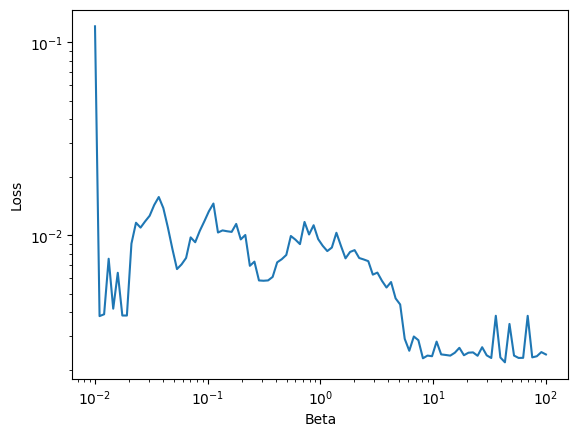

In [45]:
import matplotlib.pyplot as plt

plt.plot(betas,mse_arr.values())
plt.xscale('log', base=10)
plt.yscale('log', base=10)
plt.xlabel('Beta')
plt.ylabel('Loss')

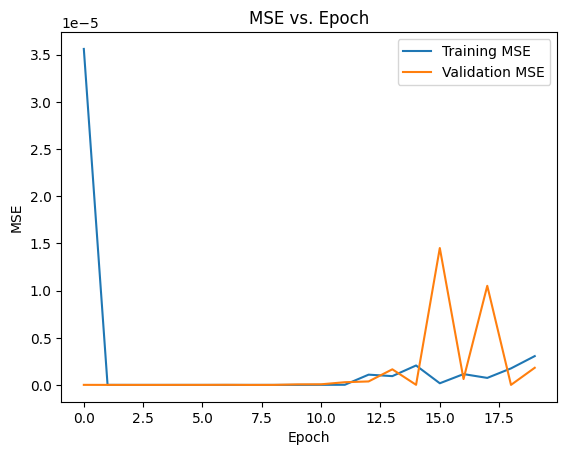

In [38]:
import matplotlib.pyplot as plt
#plt.plot(history.history['accuracy'], label='Training Accuracy')
#plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')

plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE vs. Epoch')
plt.legend()
plt.show()

# MIN LOSS = 0.0128 c/fund 50epochs MSE
##         = 0.0118 s/fund 50epochs MSE
##         = 0.0039 s/fund 50epochs MSE m=4 d=6

In [133]:
# Assuming you have a validation dataset (val_dataset)
iterador = iter(val_dataset)
sample = next(iterador)
next_sample = next(iterador)
input_data = sample[0]  # Assuming your dataset provides input data as the first element
actual_values = sample[1]  # Assuming your dataset provides actual labels as the second element

# Predict using the model
predictions = model.predict(input_data)

8/8 [==============================] - 0s 1ms/step


In [134]:
from sklearn.metrics import mean_squared_error

# Vemos algunos valores
for e in val_dataset:
    for i in range(0, 4):
        print(e[1][i])
        print(predictions[i])
    break
    

RMSE_pred = mean_squared_error(actual_values, predictions, squared=False)
RMSE_rand = mean_squared_error(actual_values, next_sample[1], squared=False)
print(RMSE_pred, RMSE_rand)

tf.Tensor(0.41295642, shape=(), dtype=float32)
[0.41389617]
tf.Tensor(0.9485647, shape=(), dtype=float32)
[0.9455778]
tf.Tensor(0.08134538, shape=(), dtype=float32)
[0.0844989]
tf.Tensor(0.5722696, shape=(), dtype=float32)
[0.5770434]
0.0038723878 0.3975444


In [95]:
m_size = basis.size
rho_1_pred = []
rho_1_actual = []
norm = []
norm_rand = []
printear =  False

for e in val_dataset:
    for i in range(0, 3 if printear else batch_size):
        # Valores actuales
        #h = e[1][i].numpy().reshape(basis.size,basis.size)
        h_true = gen_to_h(e[1][i], rho_1_arrays)
        #print(h) if printear else 0
        r = max(np.linalg.eigvals(e[0][i]))
        rho_1_actual.append(r)

        print(h_true) if printear else 0
        print(r) if printear else 0

        # Valores predichos
        #h = predictions[i].reshape(basis.size,basis.size)
        h_pred = gen_to_h(predictions[i], rho_1_arrays)
        beta = 1
        # Estado térmico
        state = thermal_state(h_pred, beta)
        # Estado puro
        #state = pure_state(h_pred)
        rho1 = np.array(rho_1(basis.d, state, rho_1_arrays))
        r = max(np.sort(linalg_d.eigvals(rho1).real))
        rho_1_pred.append(r)

        print(h_pred) if printear else 0
        print(r) if printear else 0
        

        # Normas
        norm.append(np.linalg.norm(h_true-h_pred, ord='fro'))
        print(f'Norma {norm[-1]}') if printear else 0
        ## Vamos a comparar con un h aleatorio
        size = basis.d*(basis.d+1)//2
        base = np.random.uniform(low=0, high=1.0, size=(size,))
        h_rand = gen_to_h(base, rho_1_arrays)
        norm_rand.append(np.linalg.norm(h_true-h_rand, ord='fro'))
        #print(f'Norma random {norm_rand[-1]}') if printear else 0
        print('') if printear else 0
        


    # e contiene todo el batch y nos basta con uno
    break

ValueError: cannot reshape array of size 2 into shape (1,1)

In [ ]:
print(e[1][10])
predictions[10]

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

f=1
rho_1_actual = np.array(rho_1_actual)
rho_1_pred = np.array(rho_1_pred)
#print(mean_squared_error(rho_1_pred, rho_1_actual))

print('Rho1 based statistics')
print(np.mean(np.abs(rho_1_actual-rho_1_pred)))
print(np.mean(rho_1_actual)*f)
print('std')
print(np.std(rho_1_actual-rho_1_pred)*f)
print(np.std(rho_1_actual)*f)
print(np.std(rho_1_pred)*f)
plt.hist(np.array(rho_1_pred-rho_1_actual), bins=50)
plt.show()
print('H based statistics')
print(np.mean(norm), np.mean(norm_rand))
print(np.mean(norm_rand)/np.mean(norm))


# BEST: FACTOR 1/8 c/fund
## 500 epochs, 10M dataset
# BEST: FACTOR 1/9 s/fund
## 50 epochs, 5M dataset

In [ ]:
6.25/1.30

In [ ]:
# 25 epochs d = m*2
res = {}
res[5] = 35/8.19 
res[4] = 15/2.47
res[3] = 6.2/1.73

In [ ]:
print(res)

In [ ]:
# Get the weights of all dense layers in the model
dense_weights = []
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Dense):
        weights = layer.get_weights()
        if len(weights) > 0:
            dense_weights.append(weights[0])

# Visualize the weights of each dense layer
for i, weights in enumerate(dense_weights):
    plt.figure()
    plt.imshow(weights, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title(f"Dense Layer {i+1} Weights Visualization")
    plt.show()


In [ ]:
rho_2_arrays[9,0,0,9]

0.0

In [ ]:
# Genera las matrices de rho2
def rho_2_gen(basis, mll_basis, t_basis):
    size = t_basis.size
    s = basis.size
    # La entrada i, j contiene C_j^\dag C_i    i, j \in t_basis
    mat = np.empty((size, size, s, s), dtype=np.float32)
    for i, v in enumerate(t_basis.base):
        for j, w in enumerate(t_basis.base):
            c_i = b_gen(basis, mll_basis, rep_to_exi(v))
            cdag_j = bd_gen(mll_basis, basis, rep_to_exi(w))
            mat[i, j, :, :] = np.dot(cdag_j, c_i)
            if mat[i,j,0,9] != 0:
                print(v,w)

    return mat

r = rho_2_gen(basis, basis_m2, t_basis)
r[9,0,0,9]

[0 0 0 0 1 1] [0 1 1 0 0 0]


0.0

In [ ]:
print(b_gen(basis, mll_basis, rep_to_exi([0,0,0,1,1,0])))

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [ ]:
b

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.]], dtype=float32)

In [ ]:
basis.base

array([[1, 1, 1, 0, 0, 0],
       [1, 1, 0, 1, 0, 0],
       [1, 1, 0, 0, 1, 0],
       [1, 1, 0, 0, 0, 1],
       [1, 0, 1, 1, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 0, 1],
       [1, 0, 0, 1, 1, 0],
       [1, 0, 0, 1, 0, 1],
       [1, 0, 0, 0, 1, 1],
       [0, 1, 1, 1, 0, 0],
       [0, 1, 1, 0, 1, 0],
       [0, 1, 1, 0, 0, 1],
       [0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 1],
       [0, 1, 0, 0, 1, 1],
       [0, 0, 1, 1, 1, 0],
       [0, 0, 1, 1, 0, 1],
       [0, 0, 1, 0, 1, 1],
       [0, 0, 0, 1, 1, 1]])

In [ ]:
col = 1
b = b_gen(basis, mll_basis, rep_to_exi([0,0,0,1,1,0]))
print(b.shape)
for x in range(0,b.shape[1]):
    if b[col,x] != 0:
        ind = x
        break
else:
    ind = NaN

print([basis.base[ind]], mll_basis.base[col])

(6, 20)
[array([0, 1, 0, 1, 1, 0])] [0 1 0 0 0 0]


In [ ]:
m = 3
d = 2*m
basis = fixed_basis(m, d)
t_basis = fixed_basis(2, d)
basis_m1 = fixed_basis(m-1, d)
basis_m2 = fixed_basis(m-2, d)
ml_basis = basis_m1
mll_basis = basis_m2
rho_1_arrays = rho_1_gen(basis)
rho_2_arrays = rho_2_gen(basis, mll_basis, t_basis)

In [ ]:
t_basis = fixed_basis(2, d)
mll_basis = fixed_basis(basis.m-2, d)
rho_1_arrays = rho_1_gen(basis)
rho_2_arrays = rho_2_gen(basis, mll_basis, t_basis)

In [ ]:
def two_body_hamiltonian(t_basis_size, m, energy, G, rho_1_arrays, rho_2_arrays):
    # Creamos la mat diagonal de d*d con los elementos de energy
    # cada uno de estos, se contraen con los elementos de rho_1_arrays
    # la mat energy contiene las energias de cada termino c^\dag_k c_k para k kbar (iguales)
    # por ello los elementos se repiten 
    energy_matrix = np.diagflat(np.kron(energy, np.ones(2)))
    
    # Construimos la mat de energía
    h0 = np.sum(energy_matrix[:, :, np.newaxis, np.newaxis] * rho_1_arrays[:, :, :, :], axis=(0, 1))

    # Pasamos ahora a la matrix de interacción con la misma estrategia
    # dada G que indica la interacción entre los pares k' k'bar k kbar 
    # (que son elementos particulares de t_basis)
    # transladamos estos coeficientes a una matriz en t_basis
    # y multiplicamos por rho_2_arrays
    
    # Primero determinamos, dada t_basis, cuales son los indices de pares kkbar
    offset = 4*m+1
    indices = [-(k-1)*(2*k-offset) for k in range(1,m+1)] # Lo saque de Mathmatica, vos confia
    i, j = np.meshgrid(indices, indices, indexing='ij') # Lo usamos para rellenar la mat deseada
    
    # Contruimos la mat que contraeremos con rho_2_arrays
    mat = np.zeros((t_basis_size, t_basis_size))
    mat[i, j] = G

    hi = -np.sum(mat[:, :, np.newaxis, np.newaxis] * rho_2_arrays[:, :, :, :], axis=(0, 1))

    return (h0, hi)


In [ ]:
(h02,hi2) = two_body_hamiltonian(t_basis.size, m, [0,1,2], np.ones((3,3)), rho_1_arrays, rho_2_arrays)

In [ ]:
rho_2_arrays

array([[[[1., 0., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [ ]:
print(rho_2_arrays[9,0,0,9])

0.0


In [ ]:
import numpy as np
rho_1_arrays = rho_1_gen(basis)

A = np.array([0, 1, 2])  # Your list with d elements

# Create a diagonal matrix with each element repeated twice
result_matrix = np.diagflat(np.kron(A, np.ones(2)))

print(result_matrix)
np.kron(A, np.ones(2))

mat = np.zeros((basis.size, basis.size))
for i in range(0,2*d):
    for j in range(0, 2*d):
        mat += result_matrix[i,j] * rho_1_arrays[i,j,:,:]


In [ ]:
mat = np.sum(result_matrix[:, :, np.newaxis, np.newaxis] * rho_1_arrays[:, :, :, :], axis=(0, 1))

In [ ]:
h0 == mat

In [ ]:
d = 3
t_basis = fixed_basis(2, 2*d)
basis = fixed_basis(d, 2*d)
size = t_basis.size
#basis = fixed_basis(d, 2*d)
diag_elem = []
for x in t_basis.base:
    if all([x[i] == x[i+1] for i in range(0, 2*d, 2)]):
        print(x)
        diag_elem.append(t_basis.rep_to_index(x))

print(diag_elem)
# Veamos el GALERAZO de Wolfram
n = 4*d+1
print([-(k-1)*(2*k-n) for k in range(1,d+1)])


[1 1 0 0 0 0]
[0 0 1 1 0 0]
[0 0 0 0 1 1]
[0, 9, 14]
[0, 9, 14]


In [ ]:
m2_basis = fixed_basis(2, d)
print(m2_basis.size)
nm2_basis = fixed_basis(basis.m-2, d)
print(nm2_basis.base)


In [ ]:
W = np.array([[1,2,3],[4,5,6],[7,8,9]])
index = [0,9,14]
mat = np.zeros((size,size))
for i in range(0,3):
    for j in range(0,3):
        mat[index[i], index[j]] = W[i,j]

In [ ]:
import numpy as np
rho_2_arrays = rho_2_gen(basis, nm2_basis, m2_basis)
#rho_2_arrays_tf = tf.constant(rho_2_arrays, dtype=tf.float32)

W = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
W = np.ones((3,3))
index = [0, 9, 14]
size = 15  # Assuming size is the size of the matrix

# Create a meshgrid of indices
i, j = np.meshgrid(index, index, indexing='ij')

# Use the meshgrid indices to assign values from W to the specified positions in mat
mat = np.zeros((size, size))
mat[i, j] = W

# La mat... mat corresponde a los coeficientes en t_basis
inte = np.zeros((basis.size, basis.size))
for i in range(0, t_basis.size):
    for j in range(0, t_basis.size):
        inte += - mat[i, j] * rho_2_arrays[i,j,:,:]


In [ ]:
inte == hi

In [ ]:
m = 3
basis = fixed_basis(m, d)
basis_m1 = fixed_basis(m-1, d)
basis_m2 = fixed_basis(m-2, d)

from numba import njit

# Parametros hamiltoniano
e = 1
eps = 0
e0 = np.zeros(2*d)
eigenspace_tol = 0.0001
for k in range(0, d):
    r = random.random() * eps * 0
    e0[2*k] = k*e+r
    e0[2*k+1] = k*e+r

@njit(parallel=True)
def base_hamiltonian_aux(basis, size, d, basis_m1, basis_m2):
    # Construccion de H
    d = d//2
    h0 = np.zeros((size,size), dtype=np.float32)
    for k in prange(0,2*d):
        h0 += e0[k] * np.dot(bd_aux(basis_m1, basis, k),b_aux(basis, basis_m1, k))
    hi = np.zeros((size, size), dtype=np.float32)
    for k in prange(0,d):
        for kb in prange(0,d):
            bd_terms = np.dot(bd_aux(basis_m1, basis, 2*k),bd_aux(basis_m2, basis_m1, 2*k+1))
            b_terms = np.dot(b_aux(basis_m1, basis_m2, 2*kb+1),b_aux(basis, basis_m1, 2*kb))
            hi += -1*np.dot(bd_terms,b_terms)

    return (h0, hi)

def base_hamiltonian(basis, basis_m1, basis_m2):
    return base_hamiltonian_aux(basis.base, basis.size, basis.d, basis_m1.base, basis_m2.base)

h0, hi = base_hamiltonian(basis, basis_m1, basis_m2)